# Xebra MC Calibration simulations - Clustering Prestudies

In [1]:
## Check Python version:
!python -V
## Check ROOT version:
!which root

Python 3.7.3


In [2]:
## Largest positive integer supported by the platform's Py_ssize_t type:
import sys
sys.maxsize

9223372036854775807

## Imports and function definitions

In [3]:
## Imports:

import glob

import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
from matplotlib import gridspec            # to arrange the plots nicely
%matplotlib inline

import uproot                              # uproot for easy import of ROOT tree contents
import collections                         # used for named tuples
import pandas as pd
import math
import ast
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats

In [4]:
## Function definitions:

def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]

In [5]:
## Available ROOT files in specified folder:
! ls -sh /media/ab602/TOSHIBA\ EXT/Simulation_Data/Calibration_simulations_pointsource
! ls -sh /media/ab602/TOSHIBA\ EXT/Simulation_Data/Calibration_simulations_pointsource/proc
! ls -sh /media/alex/TOSHIBA\ EXT/Simulation_Data/Calibration_simulations_pointsource
! ls -sh /media/alex/TOSHIBA\ EXT/Simulation_Data/Calibration_simulations_pointsource/proc

total 60G
 44K Co57_1.0e+05_pos_0._-122._-35.75_mm_noscint.root
344K Co57_1.0e+05_pos_0._-122._-35.75_mm_scint.root
948K Co57_1.0e+07_pos_0._-122._-35.75_mm_noscint.root
466M Co57_1.0e+07_pos_0._-45._-35.75_mm_noscint.root
6,0M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_10.root
6,0M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_1.root
6,1M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_2.root
6,2M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_3.root
6,3M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_4.root
6,3M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_5.root
6,1M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_6.root
6,0M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_7.root
6,2M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_8.root
6,0M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_9.root
6,7M Co60_1.0e+05_pos_0._-122._-35.75_mm_noscint.root
 26M Co60_1.0e+05_pos_0._-122._-35.75_mm_scint.root
624M Co60_1.0e+07_pos_0._-122._-35.75_mm_noscint.root
6,6G Co60_1.0e+07_pos_0._-45._-35.75_mm_noscint.root
3,9

In [6]:
## Selection of file to be analyzed:
isotope_name = 'Cs137' # 'Cs137', Co57', 'Co60'
filename_list = ['/media/ab602/TOSHIBA EXT/Simulation_Data/Calibration_simulations_pointsource/'+isotope_name+'_1.0e+07_pos_0._-122._-35.75_mm_noscint.root']
#filename_list = ['/media/ab602/TOSHIBA EXT/Simulation_Data/Calibration_simulations_pointsource/'+isotope_name+'_1.0e+08_pos_0._-122._-35.75_mm_noscint_1.root']
#filename_list = glob.glob("/media/ab602/TOSHIBA EXT/Simulation_Data/Calibration_simulations_pointsource/"+isotope_name+"_1.0e+08_pos_0._-122._-35.75_mm_noscint_*.root")

if len(filename_list) == 0:
    print('ERROR: No files selected!')

In [7]:
# filename prefix for automatically naming outputs

#######################
full_absorption = False
#######################

if len(filename_list) == 1:    
    filename = filename_list[0]  
else:   
    exec('n_events = '+str(len(filename_list))+'*'+filename_list[0][filename_list[0].find('e+')-3:filename_list[0].find('e+')+4])
    filename       = filename_list[0][:filename_list[0].find('e+')-3]+"{:.1e}".format(n_events)+filename_list[0][filename_list[0].find('e+')+4:-7]+'.root'
    
    
if filename.find('proc') == -1:
    filenameprefix = filename[filename.find('source/')+7:-5]
    Clustered = False
elif filename.find('proc') != -1:
    filenameprefix = filename[filename.find('proc/')+5:-5]
    Clustered = True
else:
    filenameprefix = 'filenameprefix'
    print('ERROR: Failed to set filenameprefix!')
    
    
print(filenameprefix)
print('Clustered:       '+str(Clustered))
print('Full Absorption: '+str(full_absorption))

Cs137_1.0e+07_pos_0._-122._-35.75_mm_noscint
Clustered:       False
Full Absorption: False


In [8]:
filename_list

['/media/ab602/TOSHIBA EXT/Simulation_Data/Calibration_simulations_pointsource/Cs137_1.0e+07_pos_0._-122._-35.75_mm_noscint.root']

In [9]:
if filenameprefix.find('Cs137') != -1:
    isotope_name = 'Cs137'
    isotope_name_fancy = '$^{137}$Cs'
elif filenameprefix.find('Co57') != -1:
    isotope_name = 'Co57'
    isotope_name_fancy = '$^{57}$Co'
elif filenameprefix.find('Co60') != -1:
    isotope_name = 'Co60'
    isotope_name_fancy = '$^{60}$Co'
else:
    isotope_name = ''
    isotope_name_fancy = ''
    print('ERROR: Failed to set isotope_name!')

print(isotope_name)

Cs137


## Extraction and processing of input data

In [10]:
## Inspect branches:

if Clustered == True:
    f = uproot.open(filename_list[0])['events']
    eventid = f['EventId'].array()
    f.keys()
    print(f.keys())

else:
    f = uproot.open(filename_list[0])['events/events']
    eventid = f['eventid'].array()
    f.keys()
    print(f.keys())

[b'eventid', b'ntpmthits', b'nbpmthits', b'nLSpmthits', b'nWaterpmthits', b'pmthits', b'etot', b'nsteps', b'trackid', b'type', b'parentid', b'parenttype', b'creaproc', b'edproc', b'xp', b'yp', b'zp', b'ed', b'time', b'ekin', b'pre_MomDirX', b'pre_MomDirY', b'pre_MomDirZ', b'post_MomDirX', b'post_MomDirY', b'post_MomDirZ', b'pre_ekin', b'post_ekin', b'type_pri', b'e_pri', b'xp_pri', b'yp_pri', b'zp_pri', b'xp_fcd', b'yp_fcd', b'zp_fcd', b'w_pri', b'NSave', b'Save_flag', b'Save_type', b'Save_x', b'Save_y', b'Save_z', b'Save_cx', b'Save_cy', b'Save_cz', b'Save_e', b'Save_t', b'Save_trkid']


In [11]:
## Import as panda dataframes

if Clustered == True:
    
    branches= ['xpri','ypri','zpri','Xp','Yp','Zp','Etot'] # Be careful that the branches are also initilized in _chunk_collect

    import concurrent.futures
    executor = concurrent.futures.ThreadPoolExecutor(8)

    _chunk_collect = pd.DataFrame({'xpri' : [],'ypri' : [],'zpri' : [], 'Xp' : [],'Yp' : [],'Zp' : [],'Etot' : []}) # Initialize empty data frame

    for _chunk in uproot.iterate(filename_list, "events",branches, entrysteps=100000, 
                                           outputtype=pd.DataFrame, executor=executor):
        _chunk.columns=branches
        _chunk_collect = _chunk_collect.append(_chunk) 
        print('.', end = '')
    print('\n')
        
    _chunk_collect = _chunk_collect.rename(index=str, columns={"xpri": "xp_pri", "ypri": "yp_pri", "zpri": "zp_pri", "Xp": "xp", "Yp": "yp", "Zp": "zp", "Etot": "ed"})
    
else:

    branches= ['xp_pri','yp_pri','zp_pri','xp','yp','zp','etot','ed','nsteps'] # Be careful that the branches are also initilized in _chunk_collect

    import concurrent.futures
    executor = concurrent.futures.ThreadPoolExecutor(8)

    _chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [], 'xp' : [],'yp' : [],'zp' : [],'etot' : [],'ed' : [],'nsteps' : []}) # Initialize empty data frame

    for _chunk in uproot.iterate(filename_list, "events/events",branches, entrysteps=100000, 
                                           outputtype=pd.DataFrame, executor=executor):
        _chunk.columns=branches
        #_chunk =_chunk[ _chunk['ed'].apply(lambda x: len(x)==1) ] # Remove events with more than one scatter
        #_chunk =_chunk.applymap(lambda x: x[0]) # Convert lists in cells by taking only the 0th element
        #_chunk.type_pri =_chunk.type_pri.apply(lambda x: x.decode("utf-8")) # Decode bytestrings for primary type
        _chunk_collect = _chunk_collect.append(_chunk)
        print('.', end = '')
    print('\n')

#print(_chunk.tail(10))
#_chunk_collect.tail(10)
#_chunk_collect.head(10)
#_chunk_collect

.



/home/ab602/anaconda3/lib/python3.7/site-packages/uproot/tree.py:116: FutureWarning: Int64Index.data is deprecated and will be removed in a future version
  index = awkward.numpy.frombuffer(arrays.index.data, dtype=arrays.index.dtype)


In [12]:
margin = 1

if full_absorption == True:
    filenameprefix = filenameprefix+'_fullAbsorption'
    _chunk_collect = _chunk_collect.loc[(_chunk_collect["ed"] > (661.7 - margin) )]
    
filenameprefix

'Cs137_1.0e+07_pos_0._-122._-35.75_mm_noscint'

In [13]:
_chunk_collect

,xp_pri,yp_pri,zp_pri,xp,yp,zp,etot,ed,nsteps
0,0.0,-122.0,-35.75,"[-19.215801, -20.402037, -20.402372, -20.40237...","[-7.6221175, -9.875728, -9.860348, -9.860348, ...","[-1.471887, -3.708253, -3.6498306, -3.6498306,...",661.657288,"[0.02331, 0.11917, 0.17424, 0.04792, 0.0, 0.02...",124.0
1,0.0,-122.0,-35.75,"[-21.802202, -17.835388, -17.025682, -17.02568...","[-10.620718, -8.003478, -12.174879, -12.174879...","[-24.122171, -17.198206, -26.714441, -26.71444...",661.657227,"[0.02361, 0.02331, 0.15172, 0.04653, 0.0, 0.0,...",59.0
2,0.0,-122.0,-35.75,"[-23.290302, -23.443417, -23.443417, -23.44341...","[-3.4115763, -3.3919733, -3.3919747, -3.391974...","[-40.899483, -41.070957, -41.070957, -41.07095...",471.508087,"[0.10649, 0.11715, 0.02056, 0.0, 0.04586, 0.0,...",101.0
3,0.0,-122.0,-35.75,"[25.179018, 24.869434, -18.134762, 24.869432, ...","[19.741093, 19.713095, 29.935438, 19.713093, 1...","[-9.488815, -9.393565, -23.48176, -9.393566, -...",379.923157,"[0.02331, 0.04662, 0.0, 0.04586, 0.0, 0.04514,...",29.0
4,0.0,-122.0,-35.75,"[0.14983632, -0.05433832, -0.05433807, -0.0543...","[-31.2124, -26.662691, -26.662691, -26.662691,...","[-41.705074, -44.734287, -44.734287, -44.73428...",578.380188,"[0.10172, 0.35047, 0.03321, 0.0, 0.02262, 0.0,...",111.0
5,0.0,-122.0,-35.75,"[-17.88336, -16.055225, -15.790014, -15.790013...","[-1.1912674, -1.1132278, 3.3337157, 3.333715, ...","[-19.875896, -21.688435, -21.263128, -21.26313...",661.657227,"[0.02192, 0.2355, 0.09387, 0.04447, 0.0, 0.046...",148.0
6,0.0,-122.0,-35.75,"[-1.8392564, -7.5557523, -1.8392564, -1.839256...","[17.20108, 34.174706, 17.20108, 17.20108, 17.2...","[-8.351054, -12.073705, -8.351054, -8.351054, ...",115.307945,"[0.02192, 0.0, 0.04586, 0.0, 3.3306184, 14.685...",12.0
7,0.0,-122.0,-35.75,"[7.262769, 7.2627697, 7.2627697, 7.262769, 7.2...","[-22.860489, -22.860489, -22.860489, -22.86048...","[-11.59536, -11.595361, -11.595361, -11.595359...",583.132263,"[0.18629, 0.02262, 0.0, 0.04514, 0.0, 0.04792,...",84.0
8,0.0,-122.0,-35.75,"[0.20574021, 22.347946, 34.165752, 31.022684, ...","[-30.17119, -18.236483, -7.596139, -3.170368, ...","[-38.070656, -37.060364, -43.924835, -49.4801,...",397.110565,"[0.18798, 0.04722, 0.0, 0.04722, 0.02192, 0.04...",108.0
9,0.0,-122.0,-35.75,"[22.392256, 22.392256, 22.392256, 22.392256, 2...","[-23.694553, -23.694553, -23.694553, -23.69455...","[-29.818426, -29.818426, -29.818426, -29.81842...",191.776184,"[0.19417, 0.03321, 0.0, 0.04653, 0.0, 0.04586,...",54.0


In [14]:
## Process data:

nevents = len(_chunk_collect.xp_pri)
print('nevents: '+str(nevents))

#zp_flat = flatten_tuples(_chunk_collect.zp)

nevents: 55339


In [15]:
_chunk_collect.nsteps.mean()

64.45712788449376

## Clustering

Try to extract only single scatter events -> need clustering

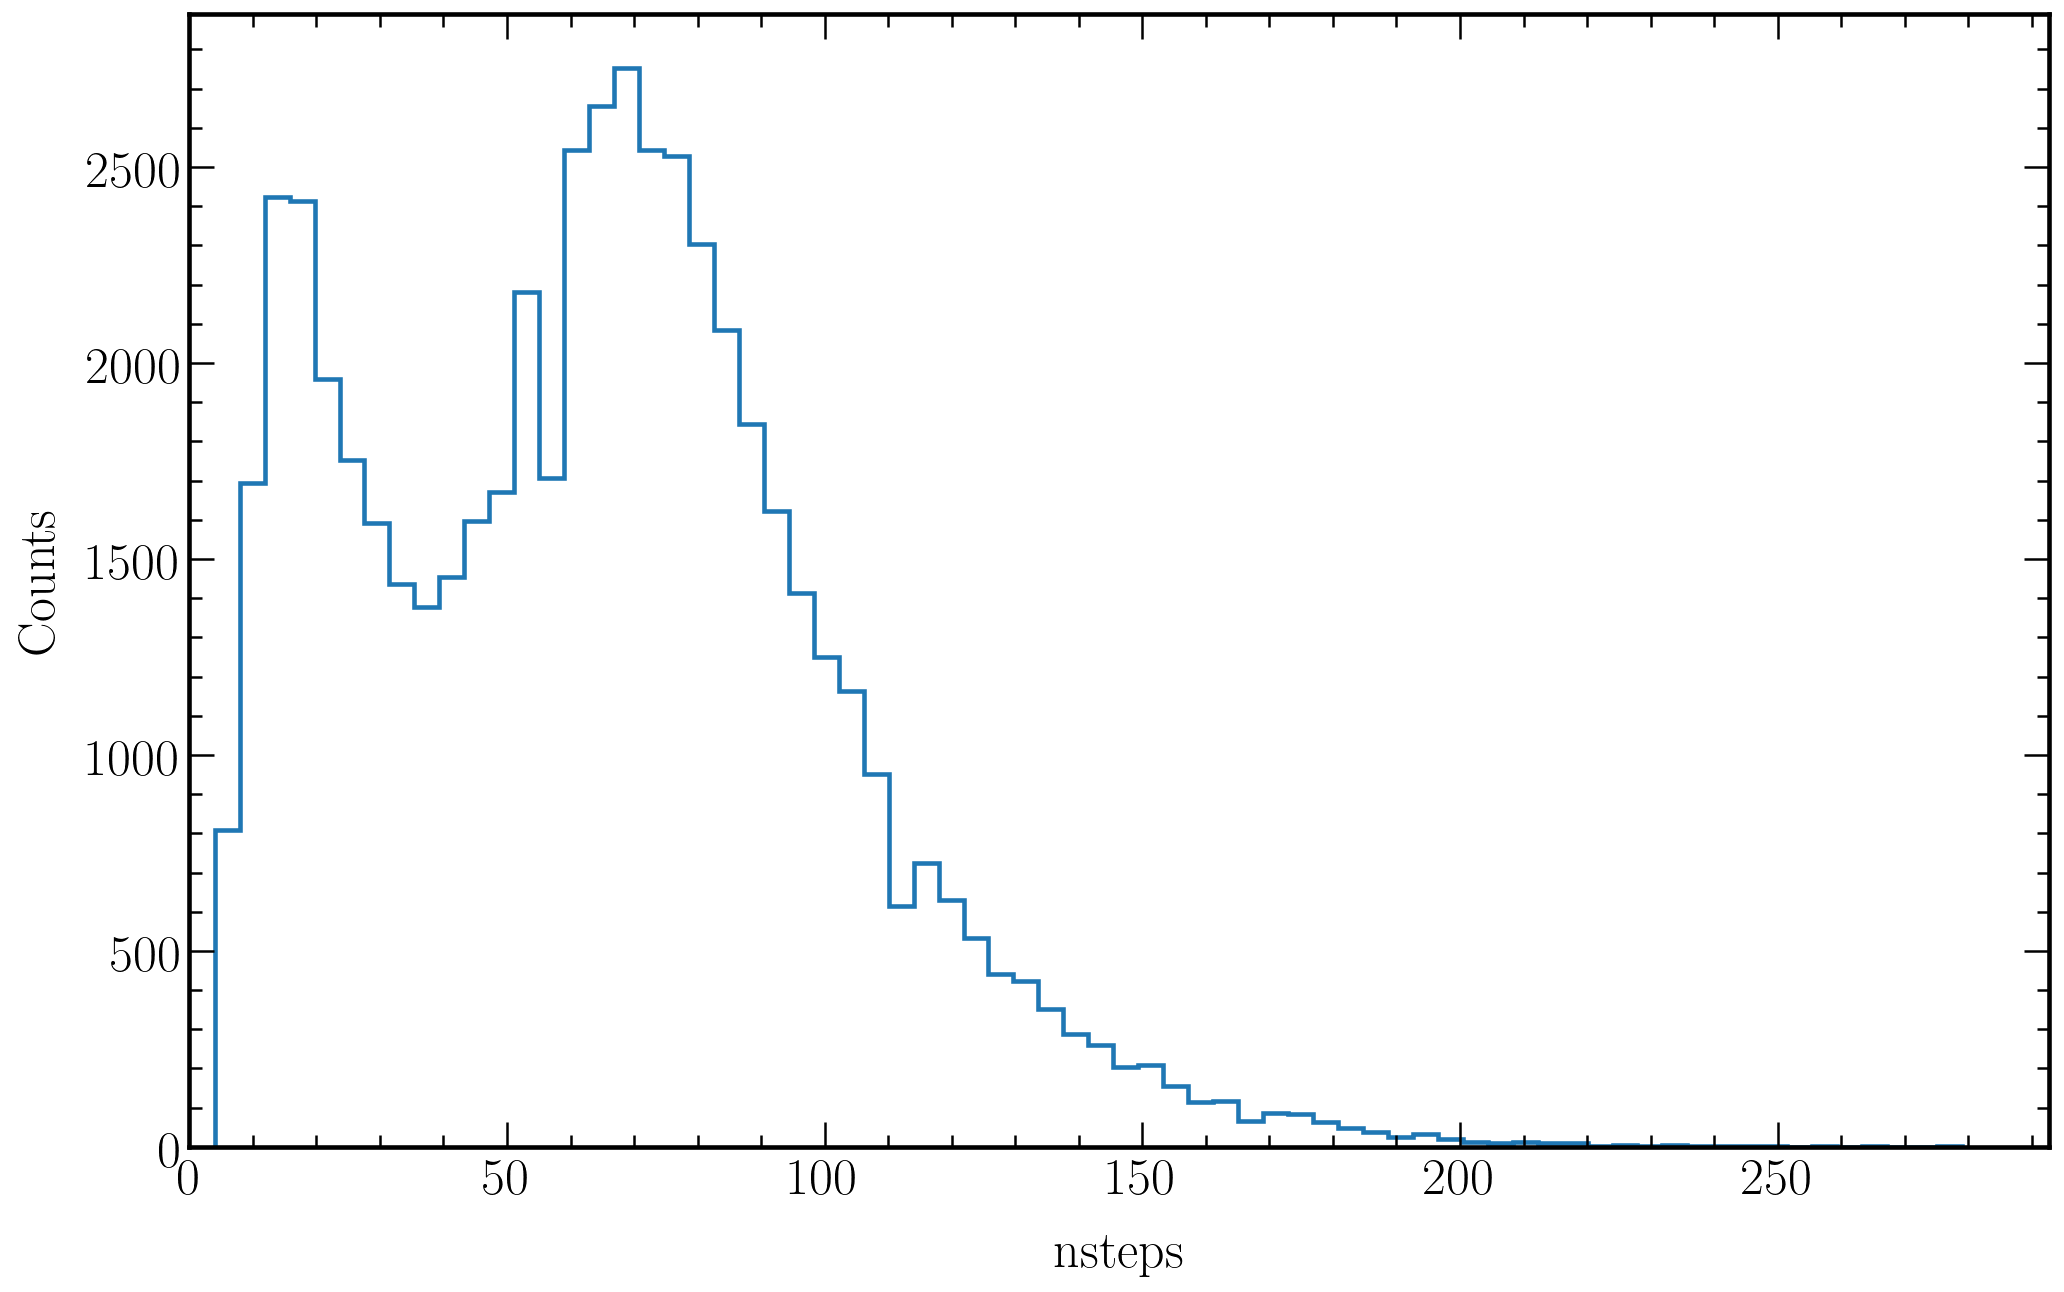

In [16]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 25
label_pad = 10
title_size = 30
title_pad = 20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(_chunk_collect.nsteps, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

plt.xlabel('nsteps', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)
#plt.title('Simulated $^{137}$Cs spectrum from total deposited energy', fontsize = title_size, pad = title_pad)

# Axes ---> Shading an area or Drawing a vertica line
#axes.axvspan(662-10, 662+10, alpha=0.5, color='0.8')
#plt.axvline(662, alpha=0.5, color='grey')

# Axes ---> Range
#plt.xlim(0,700)
#plt.ylim(0,16000)
plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_nsteps_spectrum.png")

### Exemplary interaction positions

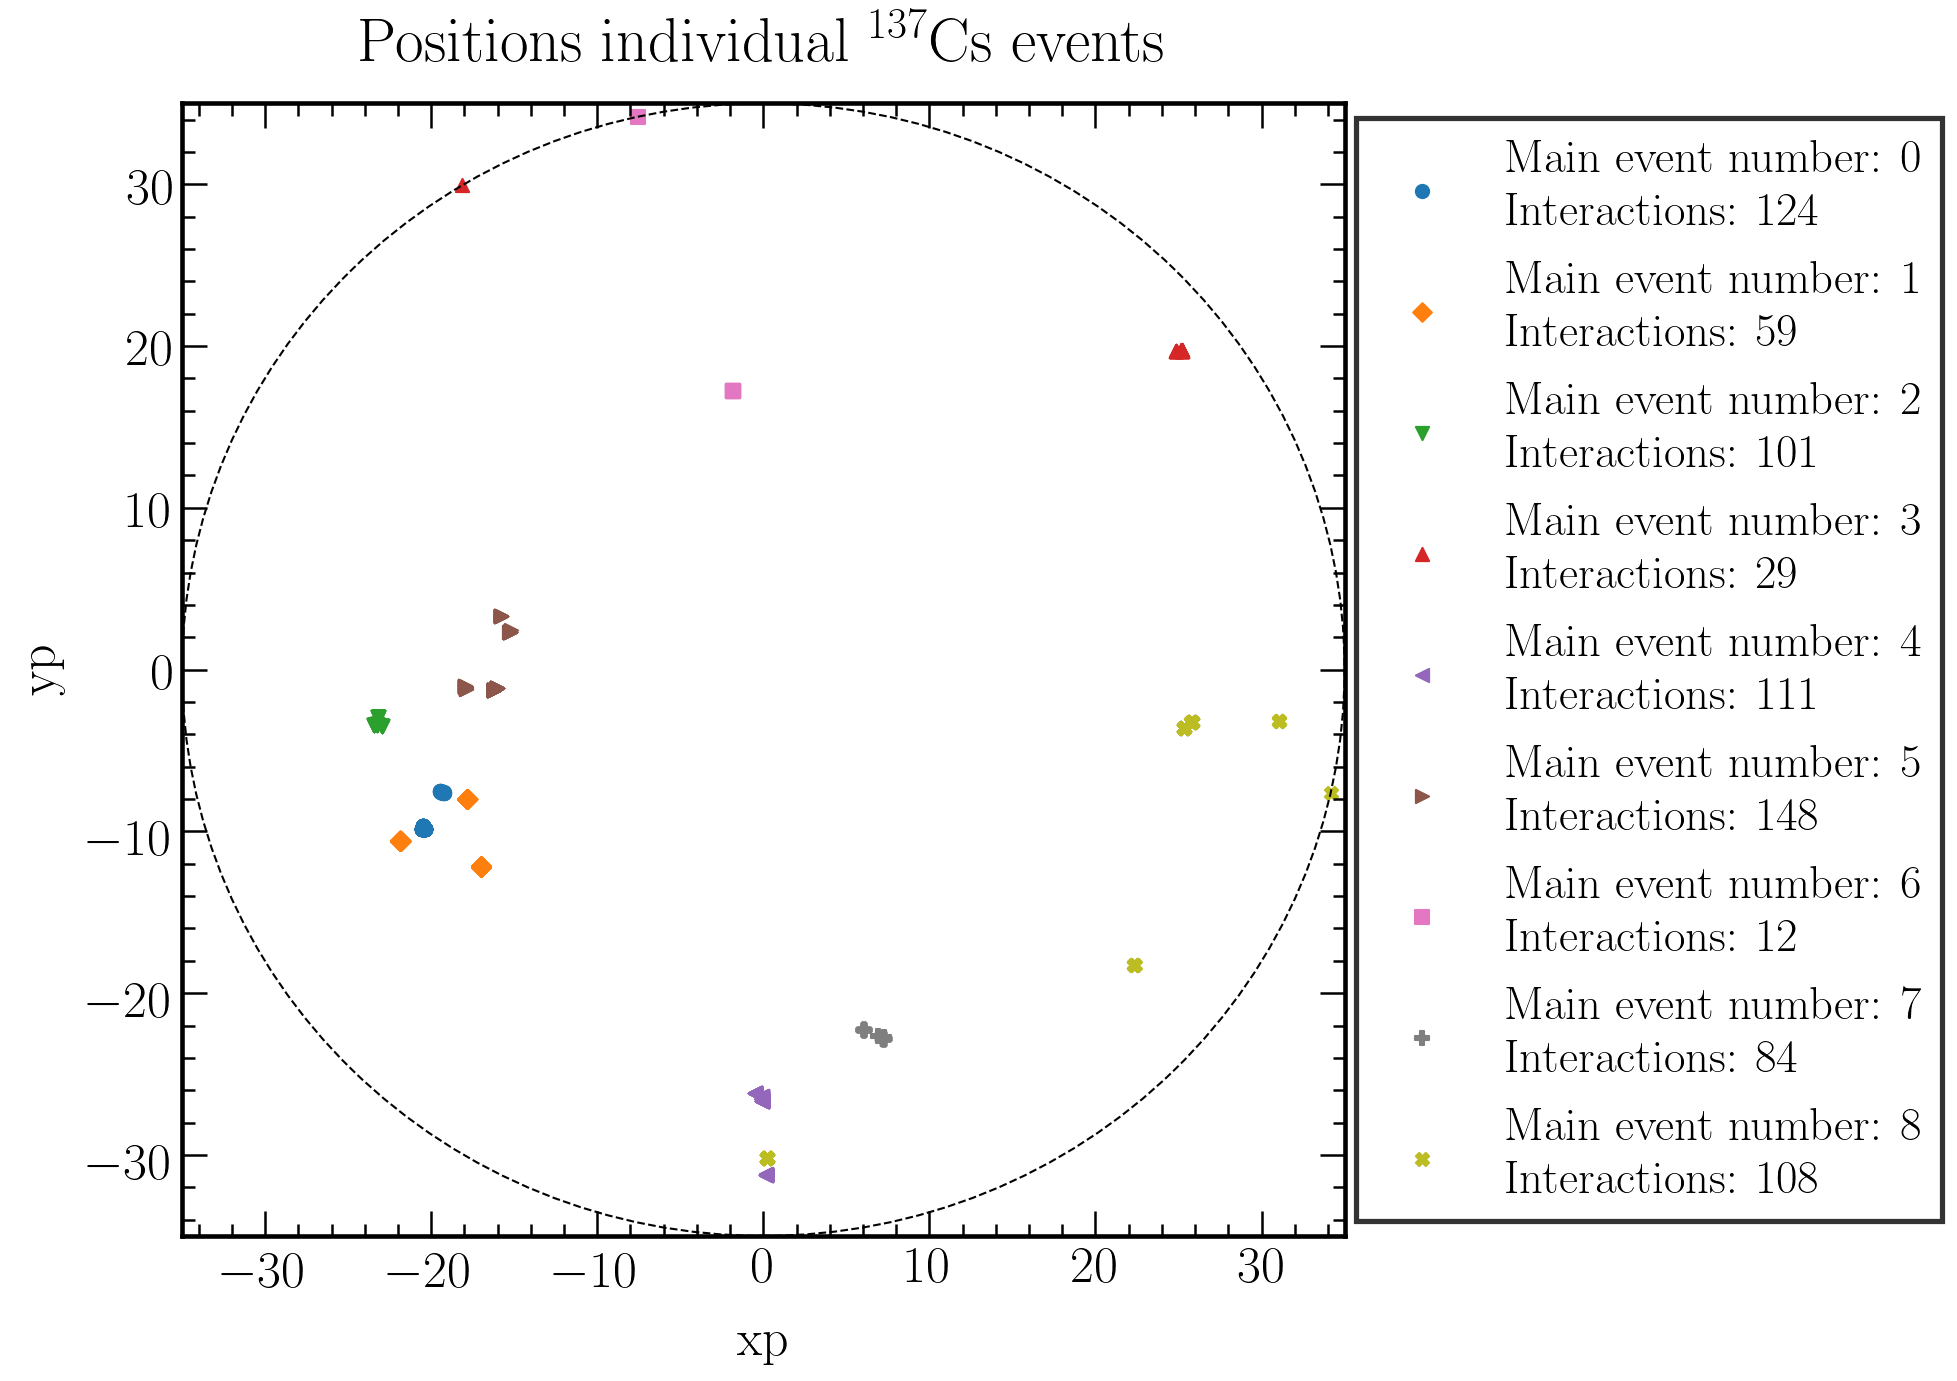

In [17]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(10, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 25
label_pad = 10
title_size = 30
title_pad = 20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
i = 0
ssize = 40
plt.scatter(_chunk_collect.xp[i], _chunk_collect.yp[i], s = ssize, marker='o', label = 'Main event number: '+str(i+0)+'\nInteractions: '+str(len(_chunk_collect.xp[0])))
plt.scatter(_chunk_collect.xp[i+1], _chunk_collect.yp[i+1], s = ssize, marker='D', label = 'Main event number: '+str(i+1)+'\nInteractions: '+str(len(_chunk_collect.xp[1])))
plt.scatter(_chunk_collect.xp[i+2], _chunk_collect.yp[i+2], s = ssize, marker='v', label = 'Main event number: '+str(i+2)+'\nInteractions: '+str(len(_chunk_collect.xp[2])))
plt.scatter(_chunk_collect.xp[i+3], _chunk_collect.yp[i+3], s = ssize, marker='^', label = 'Main event number: '+str(i+3)+'\nInteractions: '+str(len(_chunk_collect.xp[3])))
plt.scatter(_chunk_collect.xp[i+4], _chunk_collect.yp[i+4], s = ssize, marker='<', label = 'Main event number: '+str(i+4)+'\nInteractions: '+str(len(_chunk_collect.xp[4])))
plt.scatter(_chunk_collect.xp[i+5], _chunk_collect.yp[i+5], s = ssize, marker='>', label = 'Main event number: '+str(i+5)+'\nInteractions: '+str(len(_chunk_collect.xp[5])))
plt.scatter(_chunk_collect.xp[i+6], _chunk_collect.yp[i+6], s = ssize, marker='s', label = 'Main event number: '+str(i+6)+'\nInteractions: '+str(len(_chunk_collect.xp[6])))
plt.scatter(_chunk_collect.xp[i+7], _chunk_collect.yp[i+7], s = ssize, marker='P', label = 'Main event number: '+str(i+7)+'\nInteractions: '+str(len(_chunk_collect.xp[7])))
plt.scatter(_chunk_collect.xp[i+8], _chunk_collect.yp[i+8], s = ssize, marker='X', label = 'Main event number: '+str(i+8)+'\nInteractions: '+str(len(_chunk_collect.xp[8])))

plt.xlabel('xp', fontsize = label_size, labelpad = label_pad)
plt.ylabel('yp', fontsize = label_size, labelpad = label_pad)
plt.title('Positions individual '+isotope_name_fancy+' events', fontsize = title_size, pad = title_pad)

# Axes ---> Shading an area or Drawing a vertica line
#axes.axvspan(662-10, 662+10, alpha=0.5, color='0.8')
#plt.axvline(662, alpha=0.5, color='grey')

# Axes ---> Range
plt.xlim(-35,35)
plt.ylim(-35,35)

# Draw circle
ax = fig.gca()
circle1 = plt.Circle((0, 0), 35, color='black', linestyle = 'dashed', fill=False)
ax.add_artist(circle1)

# Legend
leg = plt.legend(loc=6, bbox_to_anchor=(0.99,0.5), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False) #, title="Ingredients"
leg.get_title().set_fontsize(label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5) 

plt.show()

fig.savefig(filenameprefix+"_xp_yp_exemplaryscatterplots.png", bbox_extra_artists=(leg,), bbox_inches='tight')

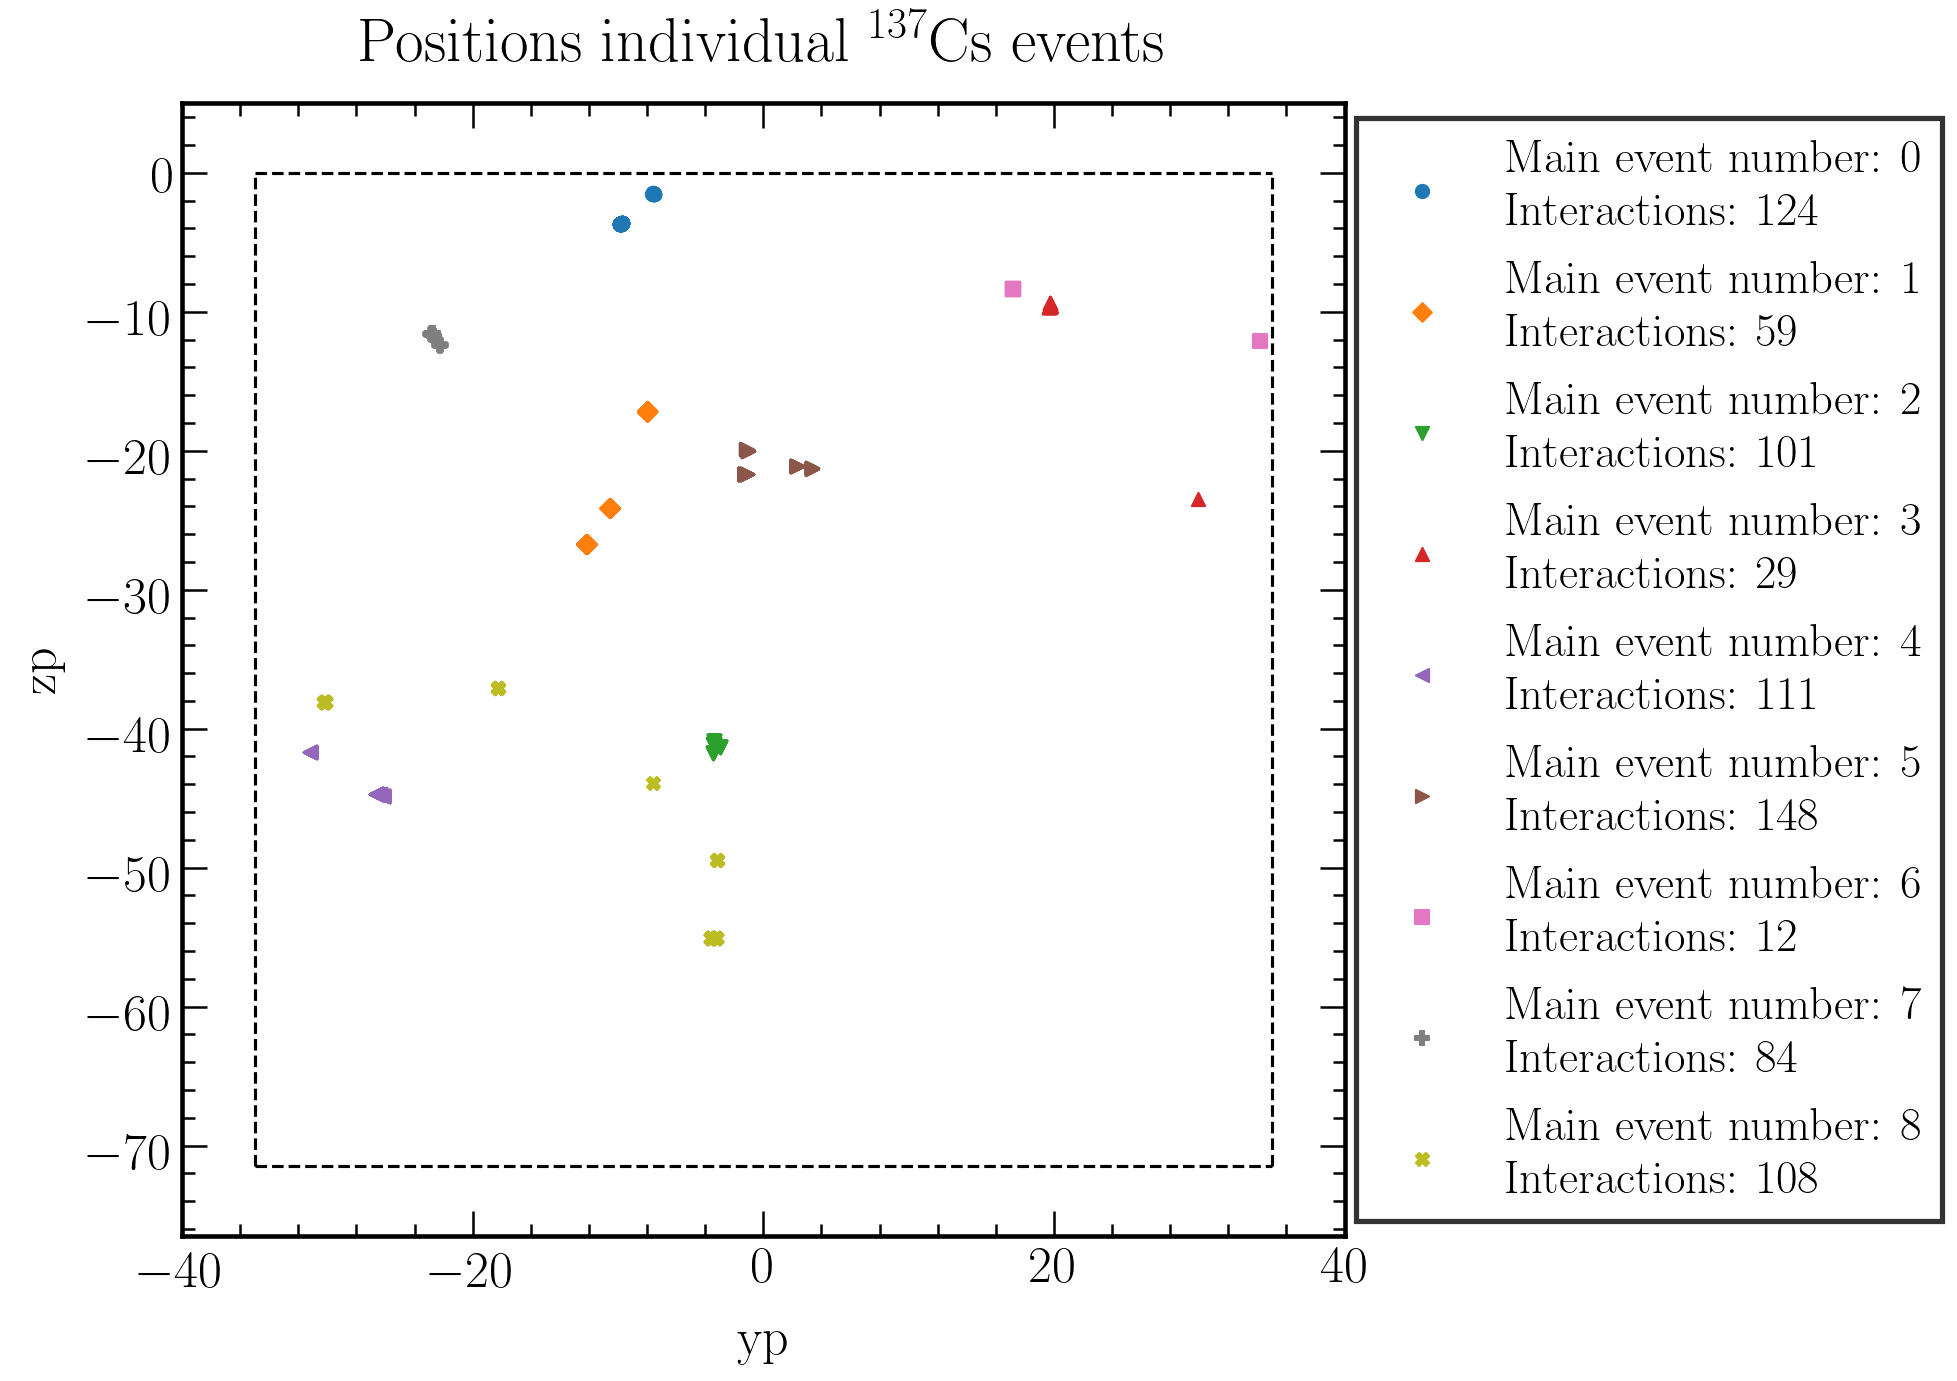

In [18]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(10, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 25
label_pad = 10
title_size = 30
title_pad = 20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
i = 0
ssize = 40
plt.scatter(_chunk_collect.yp[i], _chunk_collect.zp[i], s = ssize, marker='o', label = 'Main event number: '+str(i+0)+'\nInteractions: '+str(len(_chunk_collect.xp[0])))
plt.scatter(_chunk_collect.yp[i+1], _chunk_collect.zp[i+1], s = ssize, marker='D', label = 'Main event number: '+str(i+1)+'\nInteractions: '+str(len(_chunk_collect.xp[1])))
plt.scatter(_chunk_collect.yp[i+2], _chunk_collect.zp[i+2], s = ssize, marker='v', label = 'Main event number: '+str(i+2)+'\nInteractions: '+str(len(_chunk_collect.xp[2])))
plt.scatter(_chunk_collect.yp[i+3], _chunk_collect.zp[i+3], s = ssize, marker='^', label = 'Main event number: '+str(i+3)+'\nInteractions: '+str(len(_chunk_collect.xp[3])))
plt.scatter(_chunk_collect.yp[i+4], _chunk_collect.zp[i+4], s = ssize, marker='<', label = 'Main event number: '+str(i+4)+'\nInteractions: '+str(len(_chunk_collect.xp[4])))
plt.scatter(_chunk_collect.yp[i+5], _chunk_collect.zp[i+5], s = ssize, marker='>', label = 'Main event number: '+str(i+5)+'\nInteractions: '+str(len(_chunk_collect.xp[5])))
plt.scatter(_chunk_collect.yp[i+6], _chunk_collect.zp[i+6], s = ssize, marker='s', label = 'Main event number: '+str(i+6)+'\nInteractions: '+str(len(_chunk_collect.xp[6])))
plt.scatter(_chunk_collect.yp[i+7], _chunk_collect.zp[i+7], s = ssize, marker='P', label = 'Main event number: '+str(i+7)+'\nInteractions: '+str(len(_chunk_collect.xp[7])))
plt.scatter(_chunk_collect.yp[i+8], _chunk_collect.zp[i+8], s = ssize, marker='X', label = 'Main event number: '+str(i+8)+'\nInteractions: '+str(len(_chunk_collect.xp[8])))

plt.xlabel('yp', fontsize = label_size, labelpad = label_pad)
plt.ylabel('zp', fontsize = label_size, labelpad = label_pad)
plt.title('Positions individual '+isotope_name_fancy+' events', fontsize = title_size, pad = title_pad)

# Axes ---> Shading an area or Drawing a vertica line
#axes.axvspan(662-10, 662+10, alpha=0.5, color='0.8')
#plt.axvline(662, alpha=0.5, color='grey')

# Axes ---> Range
plt.xlim(-40,40)
plt.ylim(-76.5,5)

# Rectangle active volume
plt.plot([-35., 35.],[-71.5,-71.5], color='black', linestyle = 'dashed')
plt.plot([-35., 35.],[0,0], color='black', linestyle = 'dashed')
plt.plot([35.,35.],[-71.5,0], color='black', linestyle = 'dashed')
plt.plot([-35.,-35.],[-71.5,0], color='black', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=6, bbox_to_anchor=(0.99,0.5), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False) #, title="Ingredients"
leg.get_title().set_fontsize(label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5) 

plt.show()

fig.savefig(filenameprefix+"_yp_zp_exemplaryscatterplots.png", bbox_extra_artists=(leg,), bbox_inches='tight')

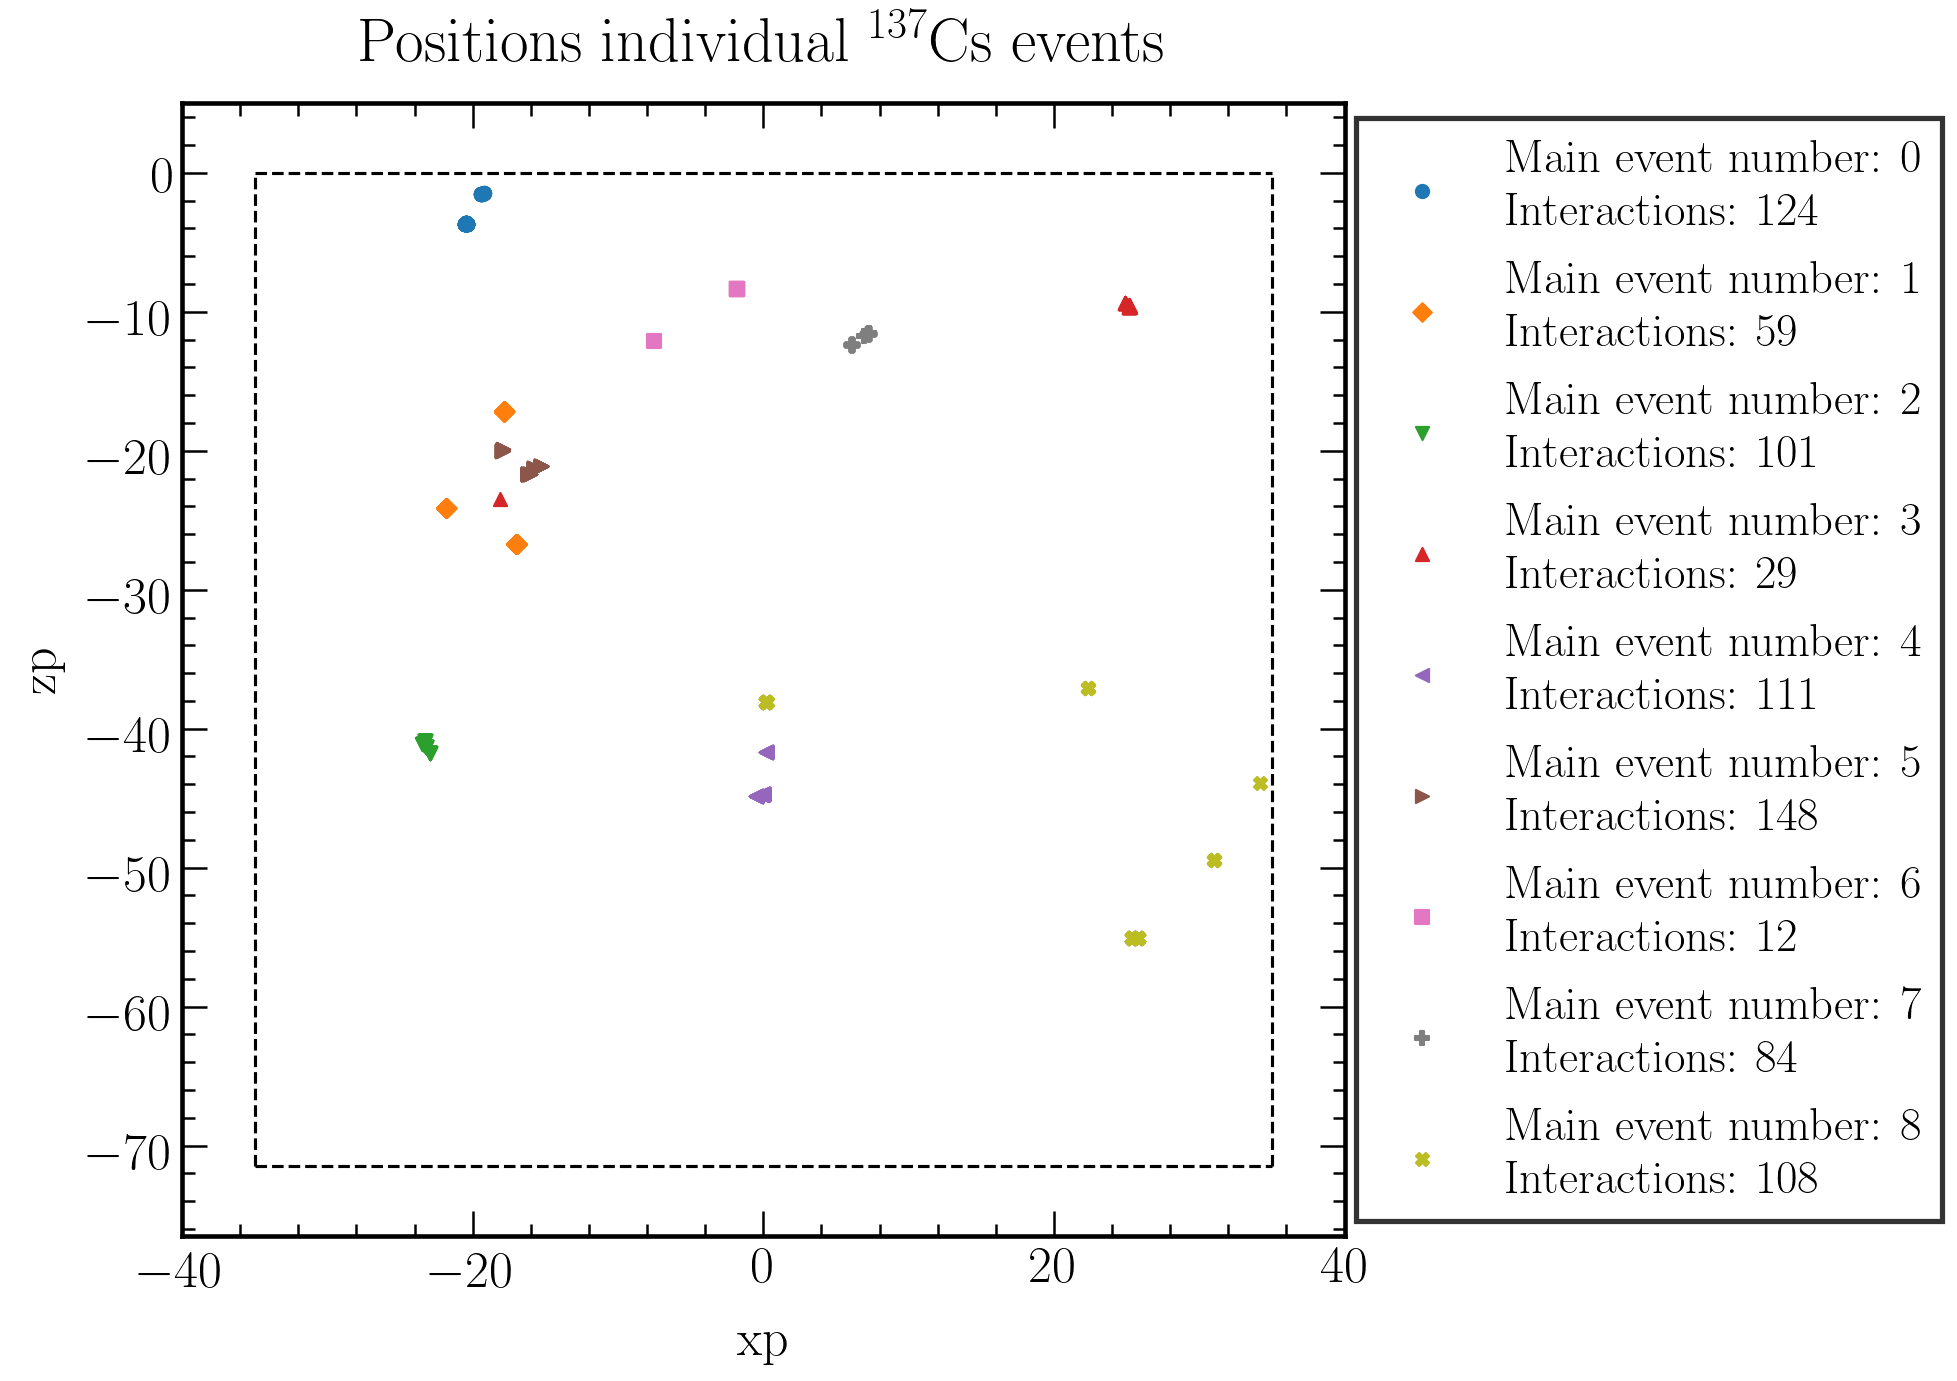

In [19]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(10, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 25
label_pad = 10
title_size = 30
title_pad = 20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
i = 0
ssize = 40
plt.scatter(_chunk_collect.xp[i], _chunk_collect.zp[i], s = ssize, marker='o', label = 'Main event number: '+str(i+0)+'\nInteractions: '+str(len(_chunk_collect.xp[0])))
plt.scatter(_chunk_collect.xp[i+1], _chunk_collect.zp[i+1], s = ssize, marker='D', label = 'Main event number: '+str(i+1)+'\nInteractions: '+str(len(_chunk_collect.xp[1])))
plt.scatter(_chunk_collect.xp[i+2], _chunk_collect.zp[i+2], s = ssize, marker='v', label = 'Main event number: '+str(i+2)+'\nInteractions: '+str(len(_chunk_collect.xp[2])))
plt.scatter(_chunk_collect.xp[i+3], _chunk_collect.zp[i+3], s = ssize, marker='^', label = 'Main event number: '+str(i+3)+'\nInteractions: '+str(len(_chunk_collect.xp[3])))
plt.scatter(_chunk_collect.xp[i+4], _chunk_collect.zp[i+4], s = ssize, marker='<', label = 'Main event number: '+str(i+4)+'\nInteractions: '+str(len(_chunk_collect.xp[4])))
plt.scatter(_chunk_collect.xp[i+5], _chunk_collect.zp[i+5], s = ssize, marker='>', label = 'Main event number: '+str(i+5)+'\nInteractions: '+str(len(_chunk_collect.xp[5])))
plt.scatter(_chunk_collect.xp[i+6], _chunk_collect.zp[i+6], s = ssize, marker='s', label = 'Main event number: '+str(i+6)+'\nInteractions: '+str(len(_chunk_collect.xp[6])))
plt.scatter(_chunk_collect.xp[i+7], _chunk_collect.zp[i+7], s = ssize, marker='P', label = 'Main event number: '+str(i+7)+'\nInteractions: '+str(len(_chunk_collect.xp[7])))
plt.scatter(_chunk_collect.xp[i+8], _chunk_collect.zp[i+8], s = ssize, marker='X', label = 'Main event number: '+str(i+8)+'\nInteractions: '+str(len(_chunk_collect.xp[8])))

plt.xlabel('xp', fontsize = label_size, labelpad = label_pad)
plt.ylabel('zp', fontsize = label_size, labelpad = label_pad)
plt.title('Positions individual '+isotope_name_fancy+' events', fontsize = title_size, pad = title_pad)

# Axes ---> Shading an area or Drawing a vertica line
#axes.axvspan(662-10, 662+10, alpha=0.5, color='0.8')
#plt.axvline(662, alpha=0.5, color='grey')

# Axes ---> Range
plt.xlim(-40,40)
plt.ylim(-76.5,5)

# Rectangle active volume
plt.plot([-35., 35.],[-71.5,-71.5], color='black', linestyle = 'dashed')
plt.plot([-35., 35.],[0,0], color='black', linestyle = 'dashed')
plt.plot([35.,35.],[-71.5,0], color='black', linestyle = 'dashed')
plt.plot([-35.,-35.],[-71.5,0], color='black', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=6, bbox_to_anchor=(0.99,0.5), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False) #, title="Ingredients"
leg.get_title().set_fontsize(label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5) 

plt.show()

fig.savefig(filenameprefix+"_xp_zp_exemplaryscatterplots.png", bbox_extra_artists=(leg,), bbox_inches='tight')

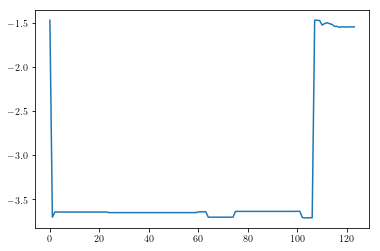

In [20]:
i = 0
plt.plot(range(0, len(_chunk_collect.zp[i])), _chunk_collect.zp[i])
plt.show()

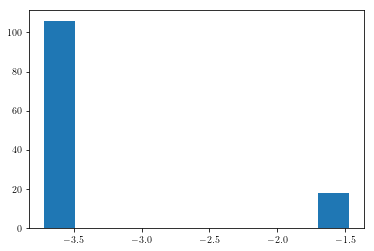

In [21]:
i = 0
plt.hist(_chunk_collect.zp[i])
plt.show()

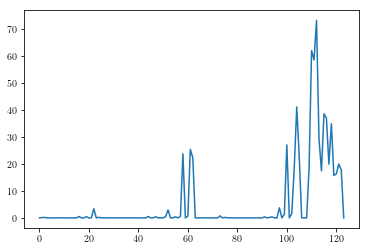

In [22]:
i = 0
plt.plot(range(0, len(_chunk_collect.ed[i])), _chunk_collect.ed[i])
#plt.yscale('log')
plt.show()

124


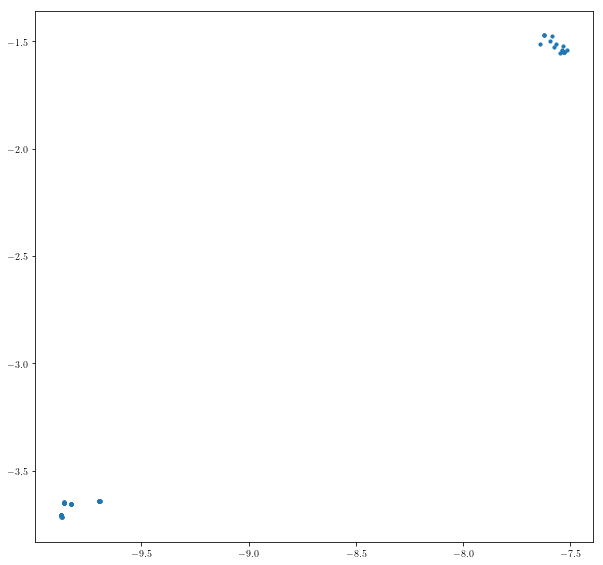

In [23]:
fig=plt.figure(figsize=(10, 10))

i = 0
plt.scatter(_chunk_collect.yp[i], _chunk_collect.zp[i], s = 10,marker='o')
print(len(_chunk_collect.zp[i]))
               
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Estimation cluster size

In [24]:
(np.array([-1,0,1,2])>0).astype(int)

array([0, 0, 1, 1])

In [25]:
zp_mins = np.zeros(len(_chunk_collect.zp))
for i in range(0, len(_chunk_collect.zp)):
    zp_mins[i] = _chunk_collect.zp[i].min()

In [26]:
zp_diffsmin = _chunk_collect.zp - zp_mins

In [27]:
zp_diffsmin_flat = flatten_tuples(zp_diffsmin)

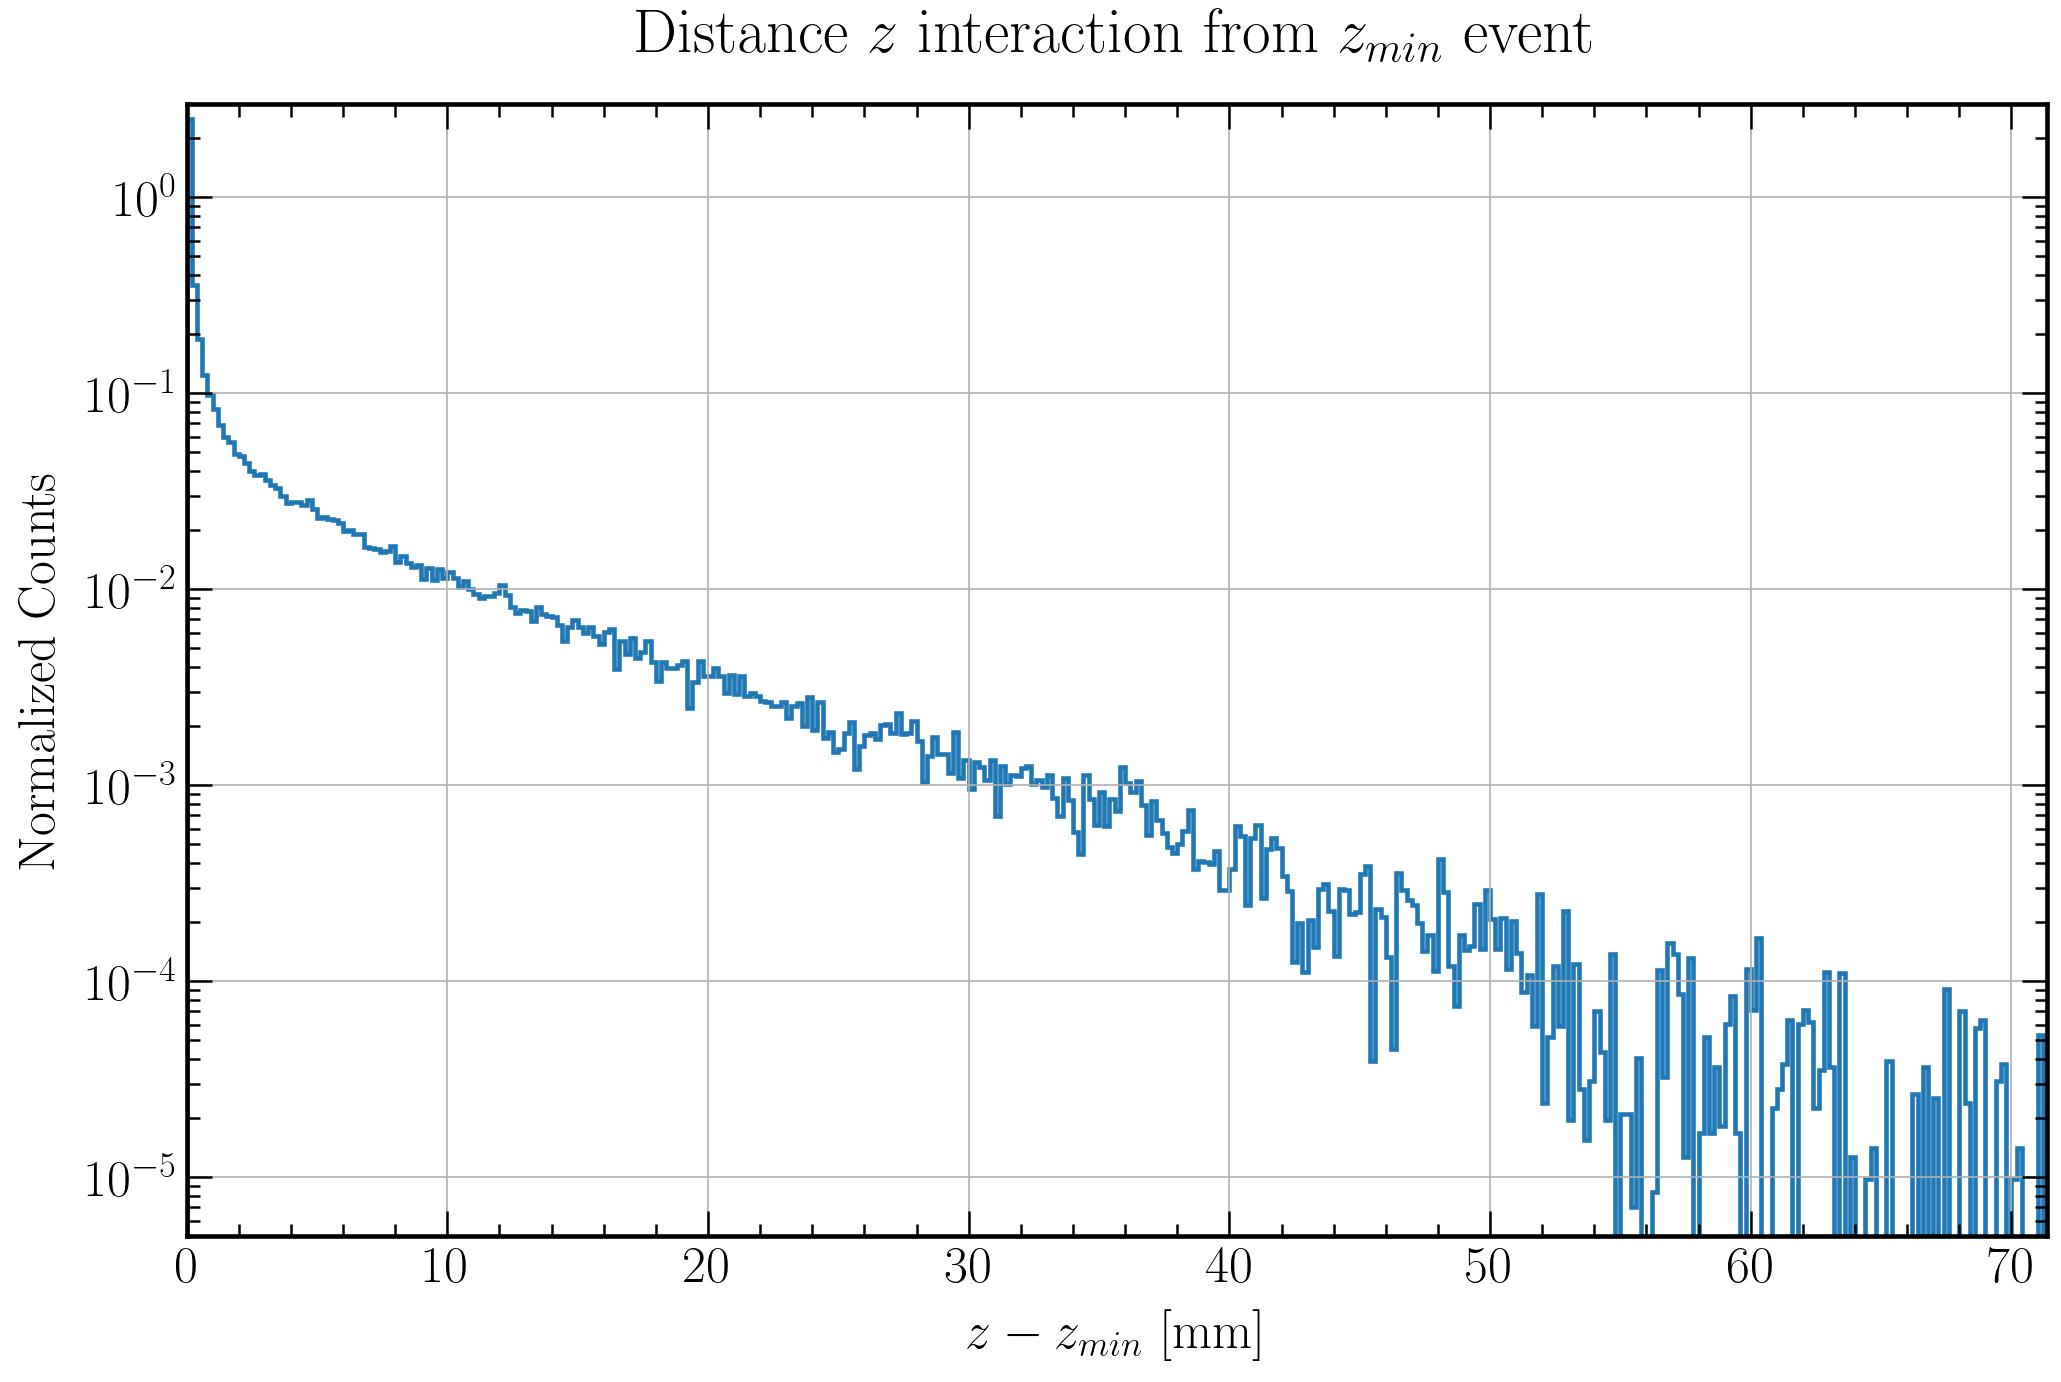

In [28]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 25
label_pad = 10
title_size = 30
title_pad = 20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = int(71.2*5)

# Data plot
plt.hist(zp_diffsmin_flat, numberbins, log=True, density = True, histtype = 'step', linewidth = 2.2)

plt.xlabel('$z - z_{min}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Normalized Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Distance $z$ interaction from $z_{min}$ event', fontsize = title_size, pad = title_pad)

# Axes ---> Range
plt.xlim(0,71.35)
plt.ylim(5e-6,3)

fig.savefig(filenameprefix+"_z-zmin.png")
plt.show()

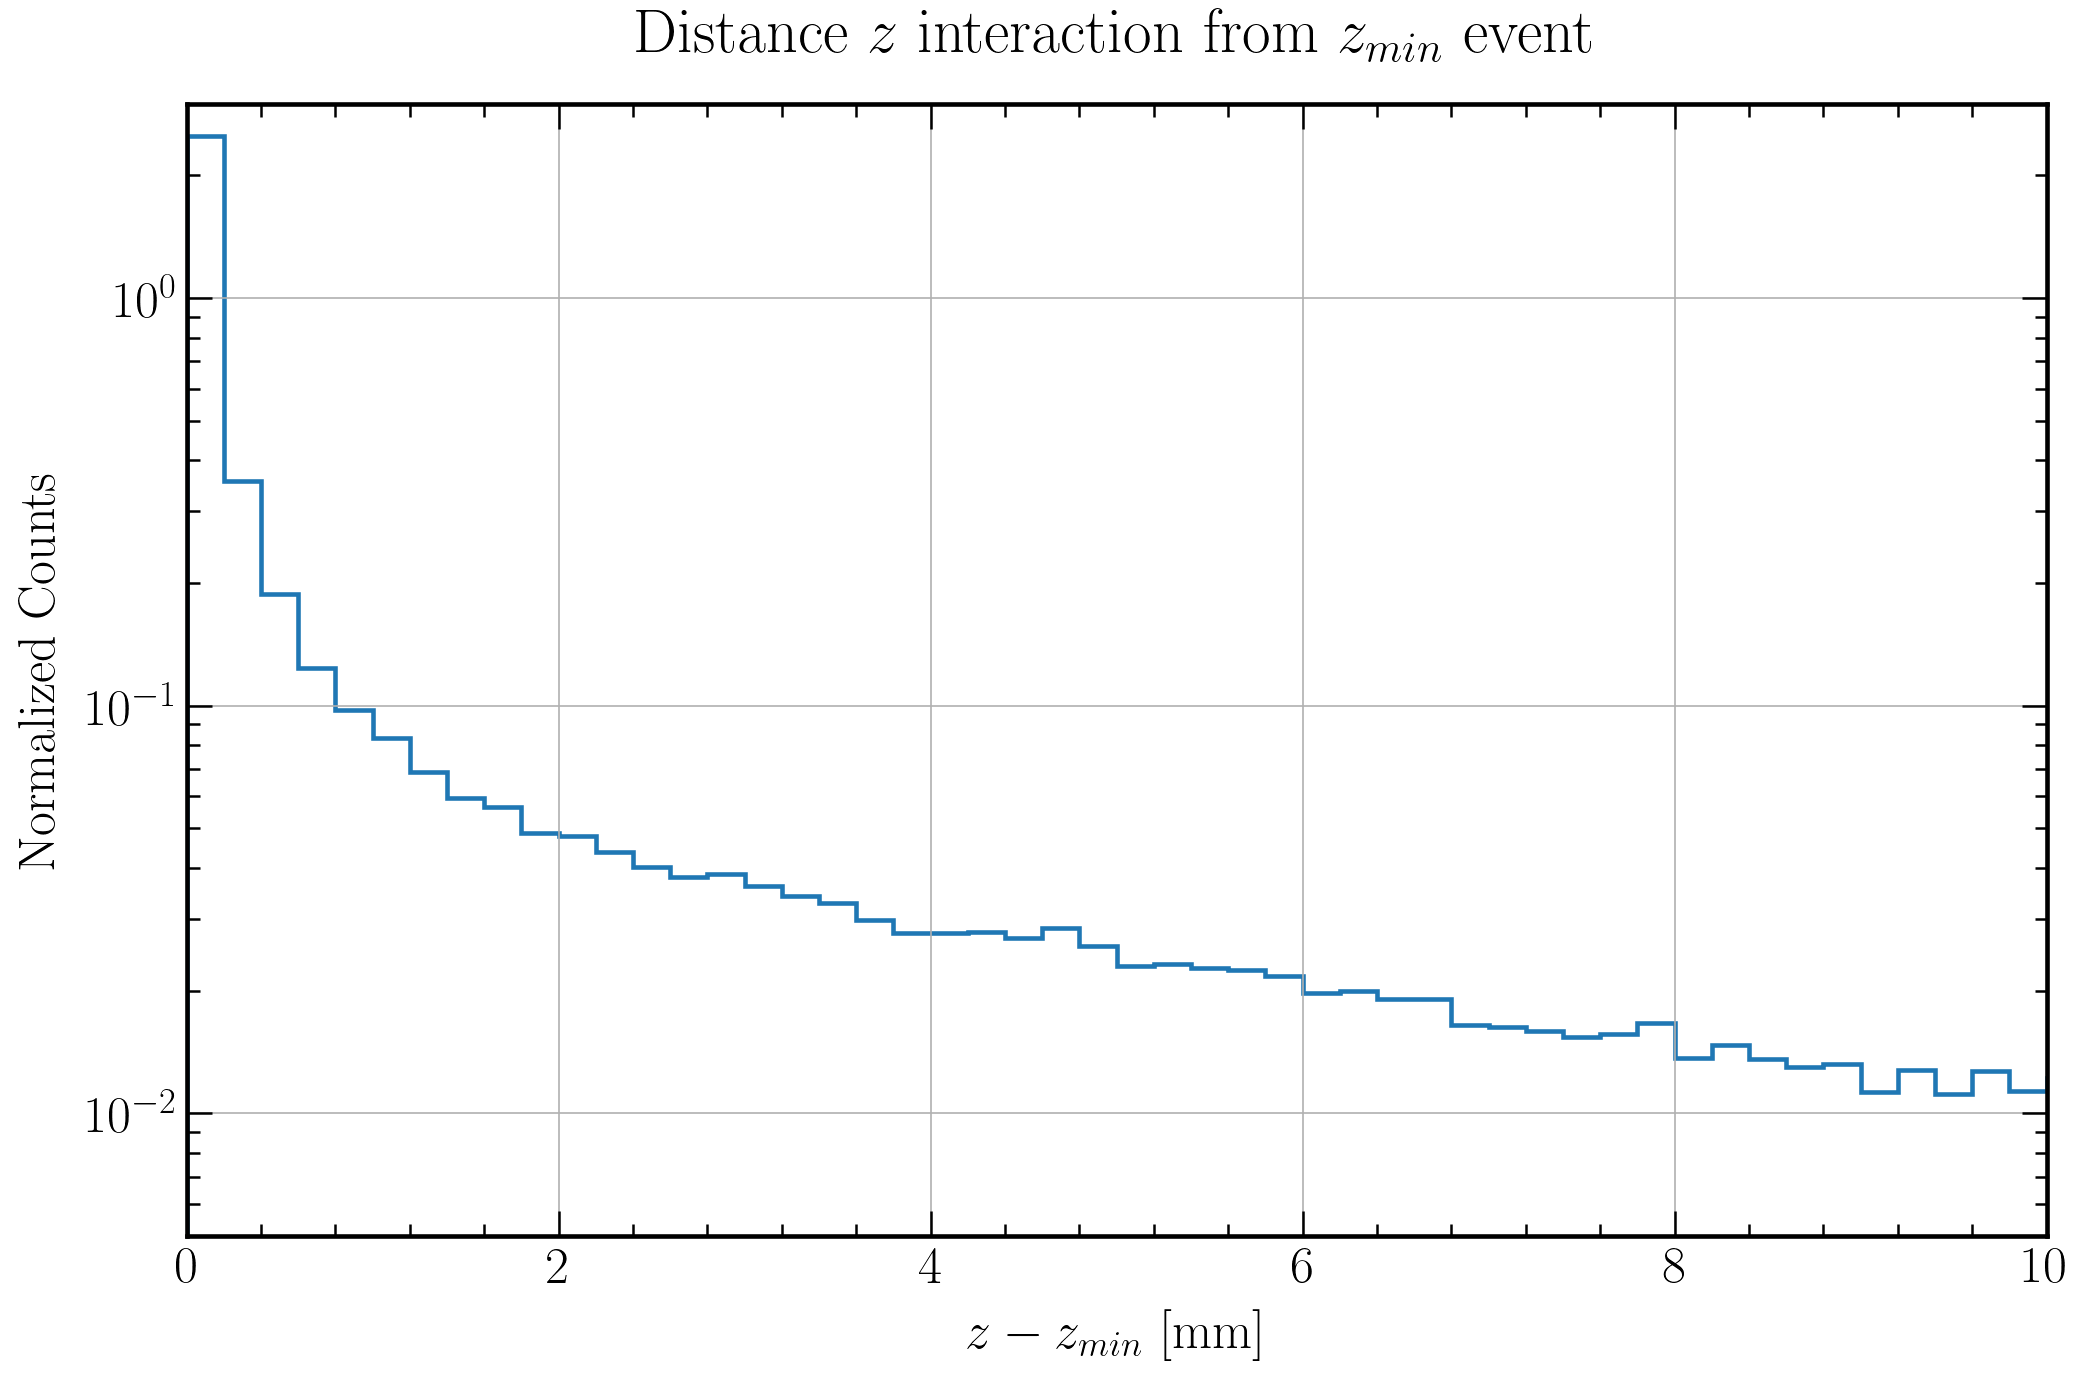

In [29]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 25
label_pad = 10
title_size = 30
title_pad = 20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = int(71.2*5)

# Data plot
plt.hist(zp_diffsmin_flat, numberbins, log=True, density = True, histtype = 'step', linewidth = 2.2)

plt.xlabel('$z - z_{min}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Normalized Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Distance $z$ interaction from $z_{min}$ event', fontsize = title_size, pad = title_pad)

# Axes ---> Range
plt.xlim(0,10)
plt.ylim(0.005,3)

fig.savefig(filenameprefix+"_z-zmin_zoom.png")
plt.show()

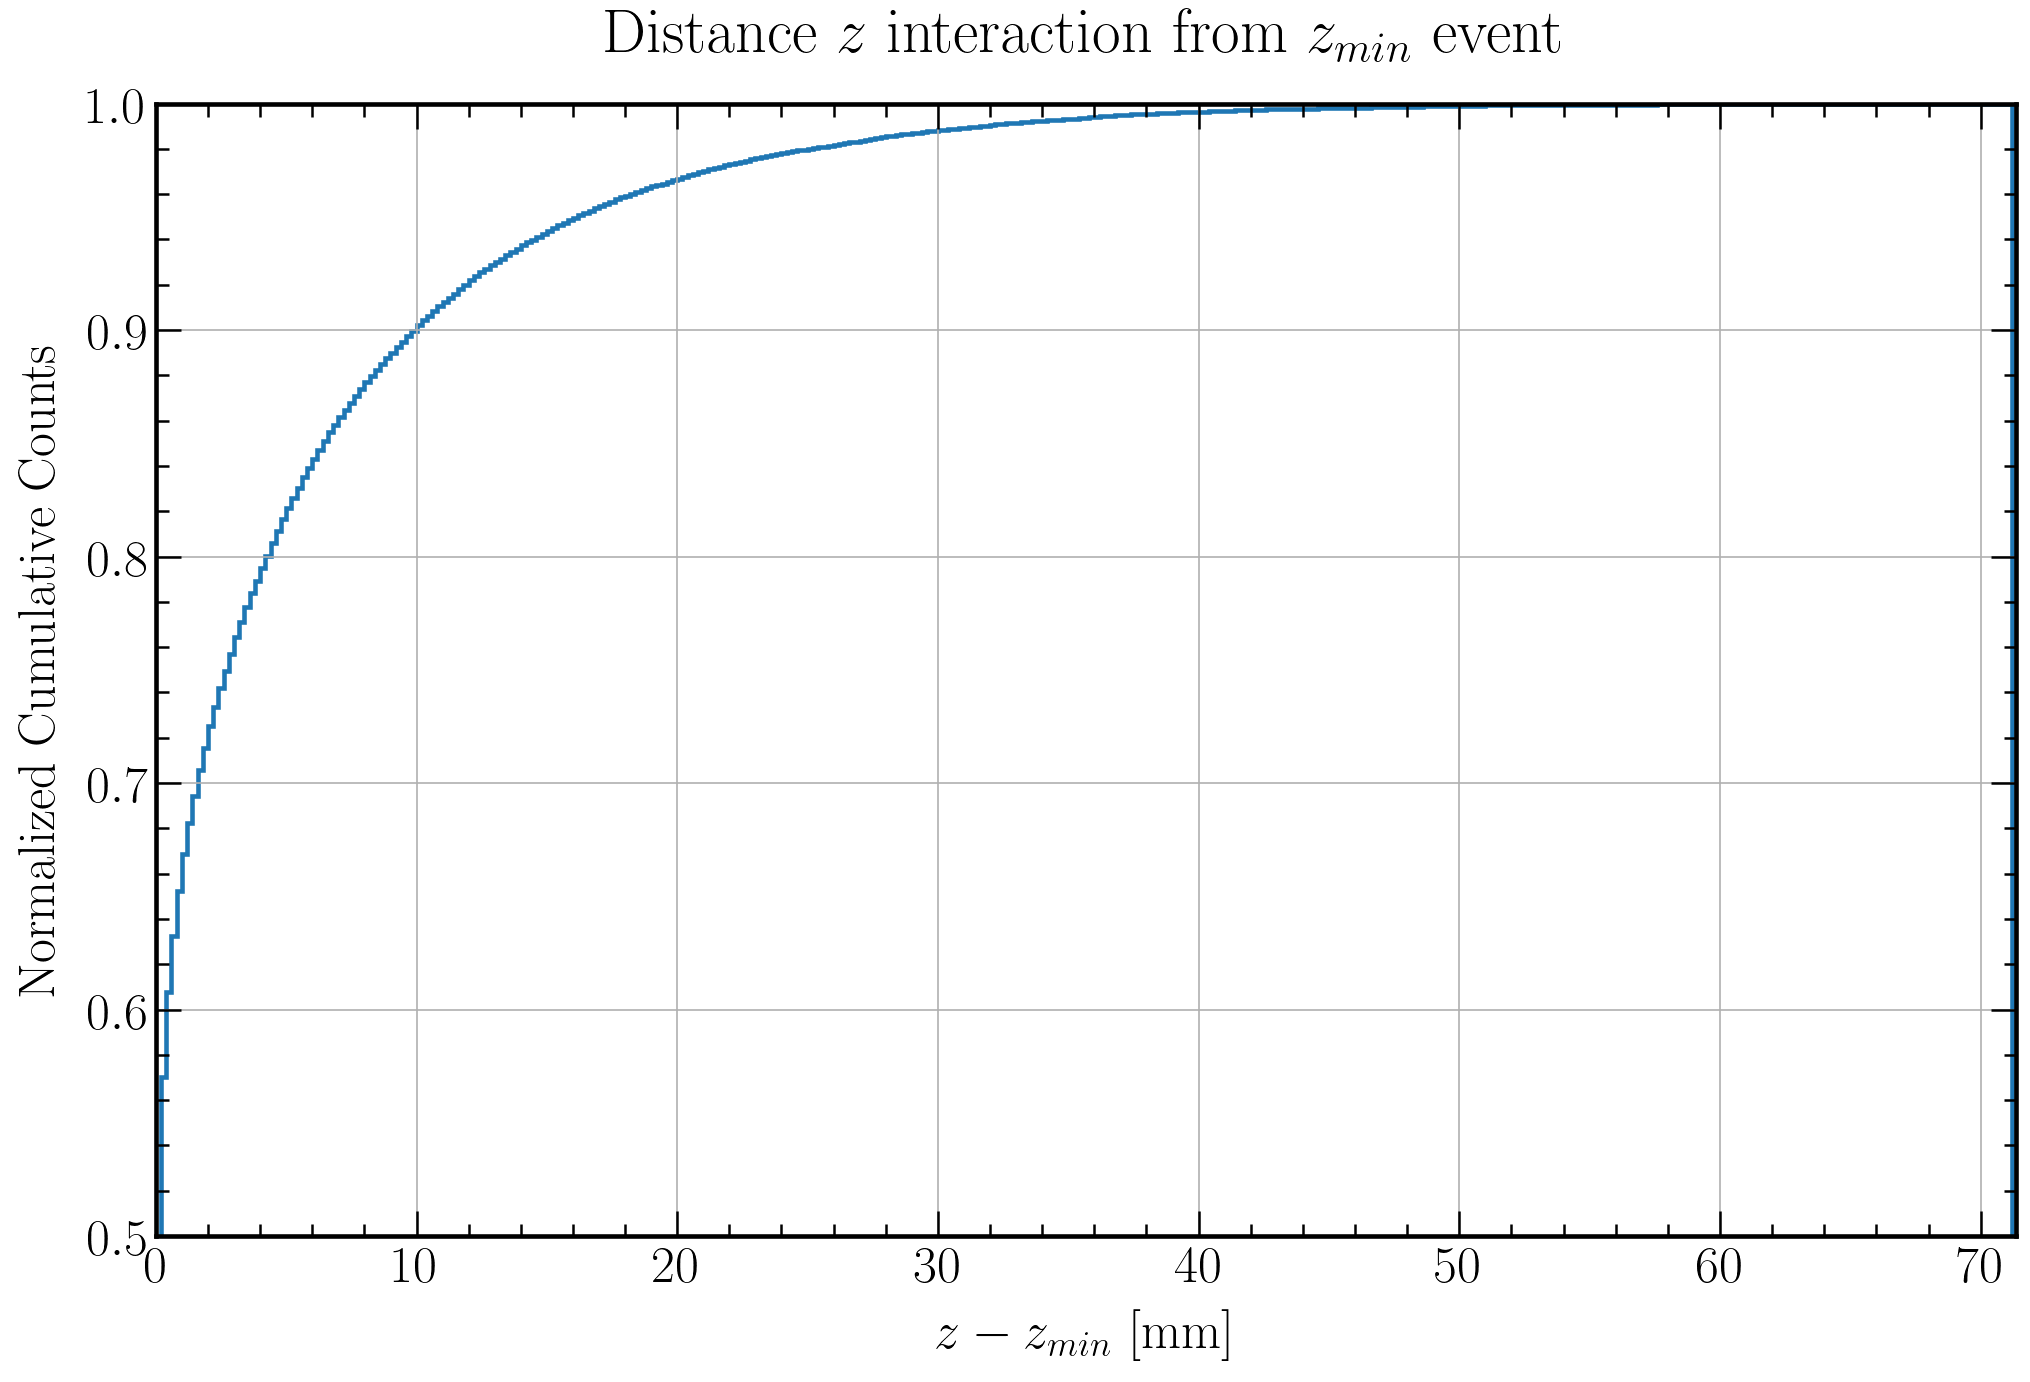

In [30]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 25
label_pad = 10
title_size = 30
title_pad = 20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = int(71.2*5)

# Data plot
plt.hist(zp_diffsmin_flat, numberbins, cumulative=True, density = True, histtype = 'step', linewidth = 2.2)

plt.xlabel('$z - z_{min}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Normalized Cumulative Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Distance $z$ interaction from $z_{min}$ event', fontsize = title_size, pad = title_pad)

# Axes ---> Range
plt.xlim(0,71.35)
plt.ylim(0.5,1.0)

fig.savefig(filenameprefix+"_z-zmin_cumulative.png")
plt.show()

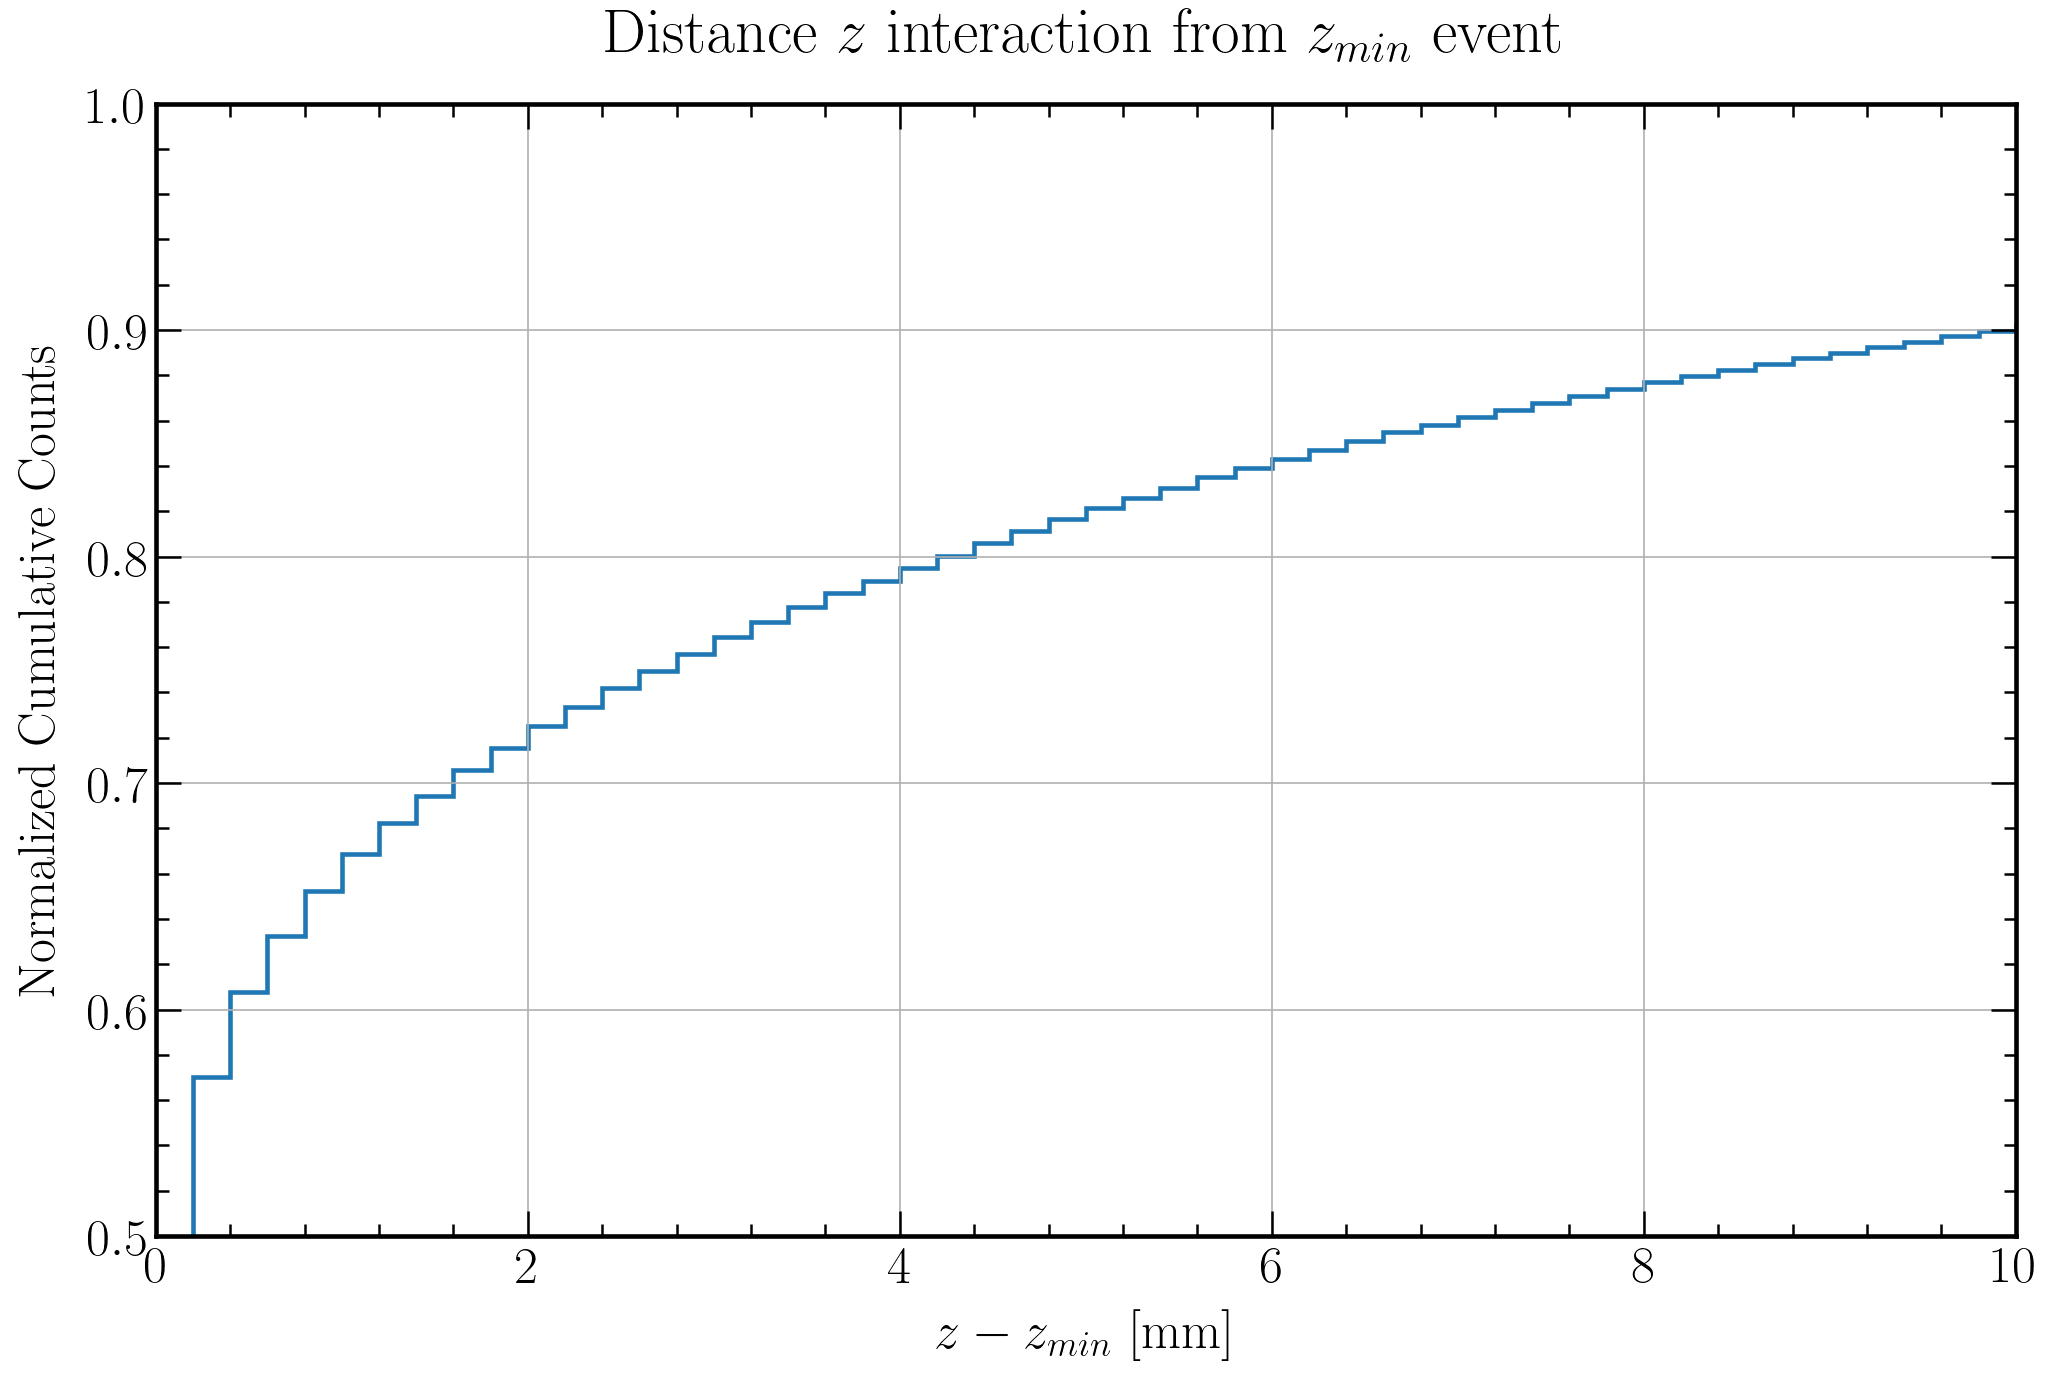

In [31]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 25
label_pad = 10
title_size = 30
title_pad = 20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = int(71.2*5)

# Data plot
plt.hist(zp_diffsmin_flat, numberbins, cumulative=True, density = True, histtype = 'step', linewidth = 2.2)

plt.xlabel('$z - z_{min}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Normalized Cumulative Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Distance $z$ interaction from $z_{min}$ event', fontsize = title_size, pad = title_pad)

# Axes ---> Range
plt.xlim(0,10)
plt.ylim(0.5,1)

fig.savefig(filenameprefix+"_z-zmin_cumulative_zoom.png")
plt.show()

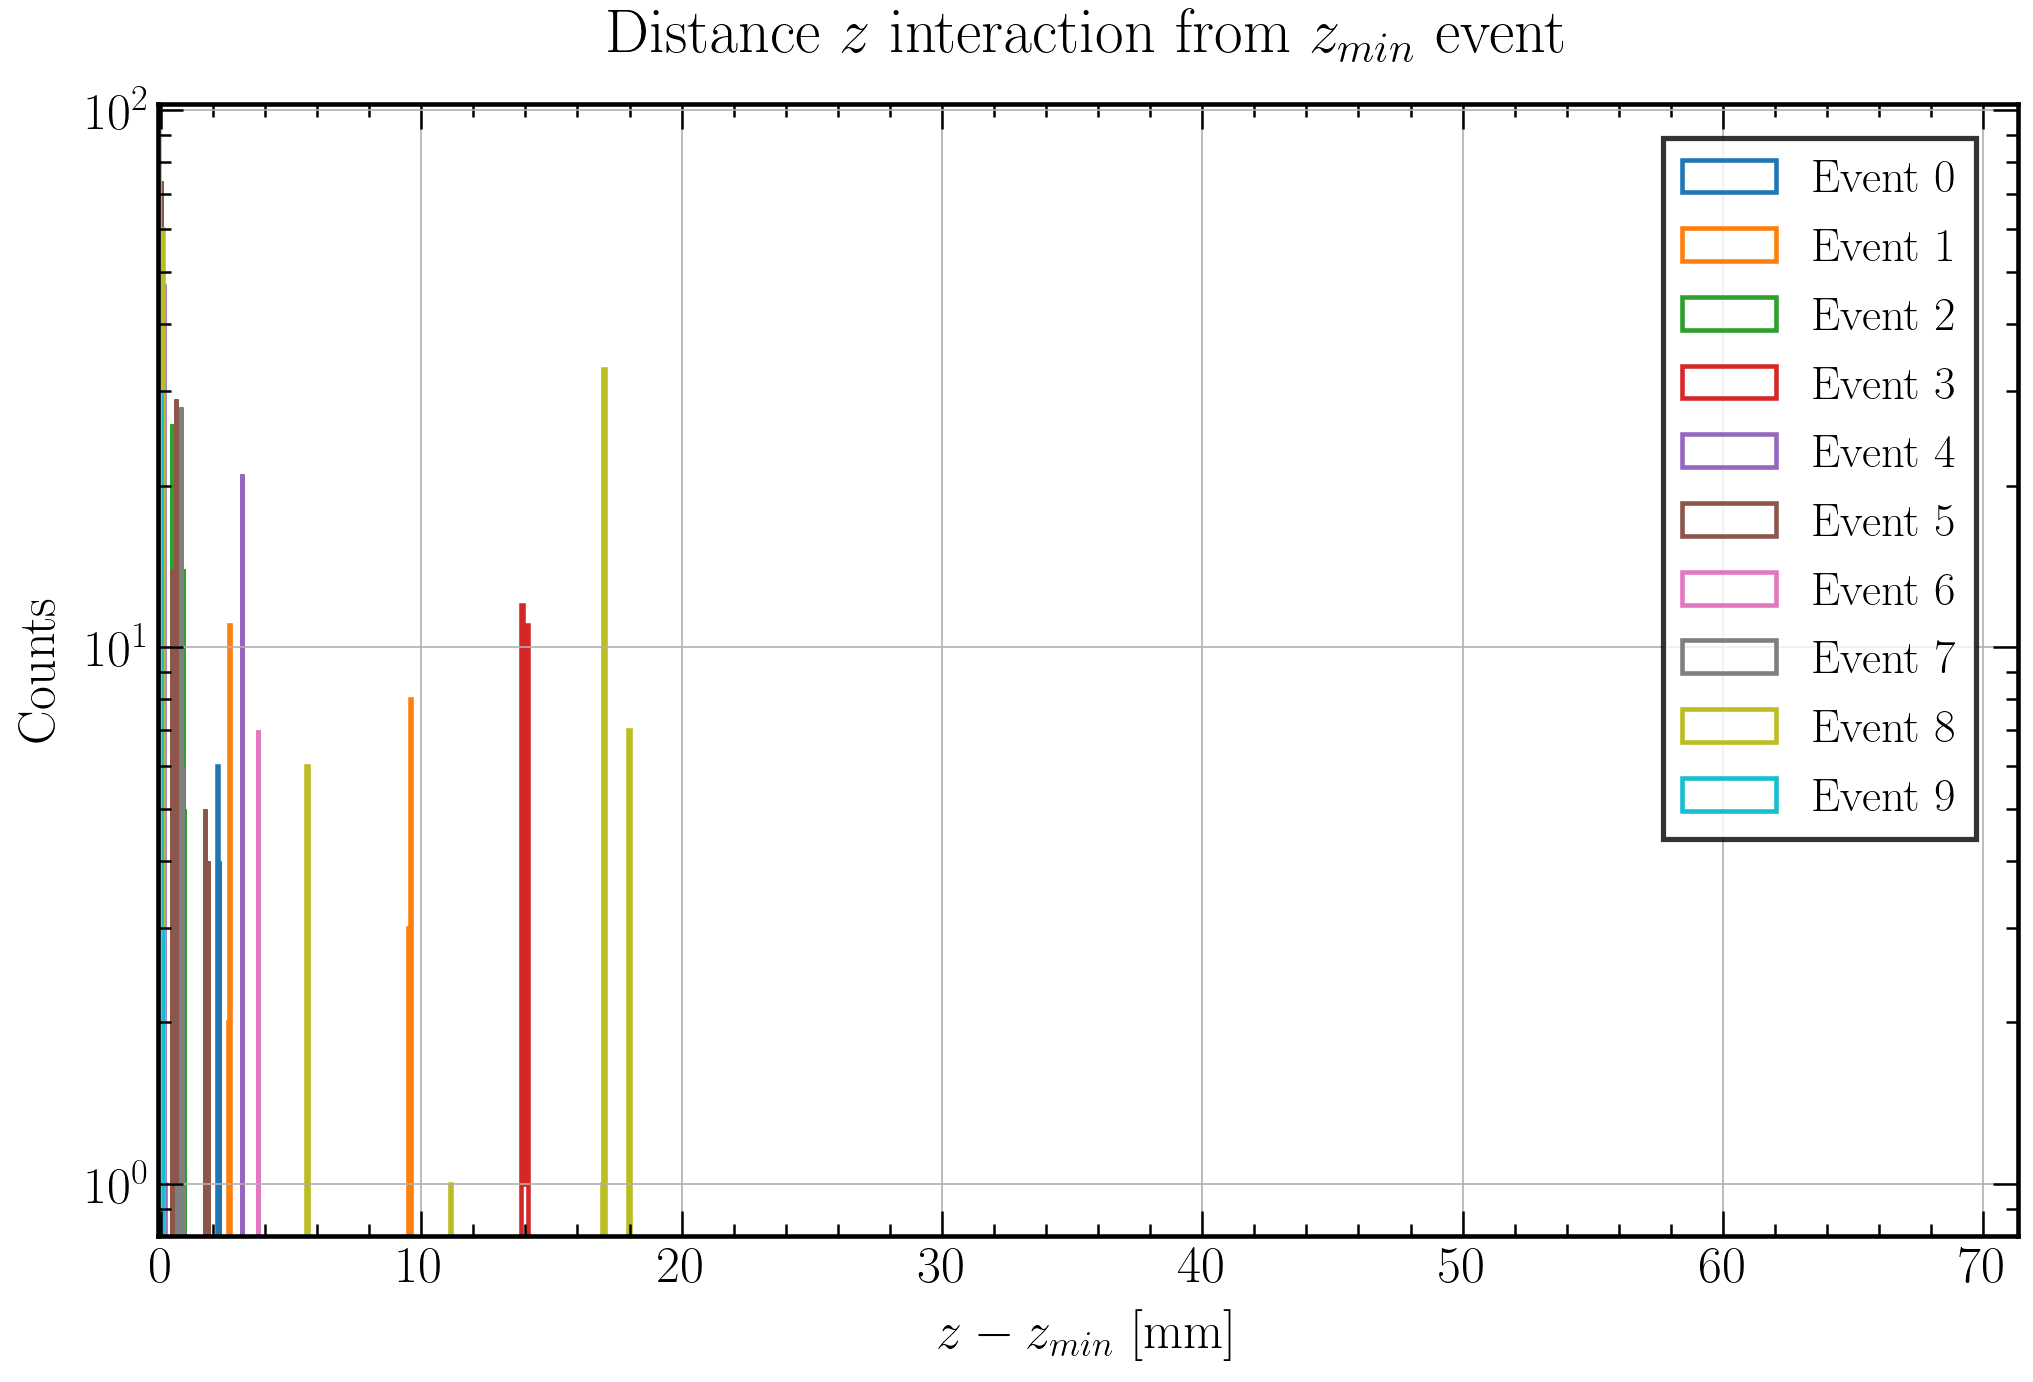

In [32]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 25
label_pad = 10
title_size = 30
title_pad = 20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = int(71.2*4)

# Data plot
i = 0
for i in range(0,10):
    plt.hist(zp_diffsmin[i], numberbins, label = 'Event '+str(i), log=True, density = False, histtype = 'step', linewidth = 2.2)


plt.xlabel('$z - z_{min}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Distance $z$ interaction from $z_{min}$ event', fontsize = title_size, pad = title_pad)

# Axes ---> Range
plt.xlim(-0.1,71.35)
plt.ylim(bottom = 0.8)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False) #, title="Ingredients"
leg.get_title().set_fontsize(label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5) 

fig.savefig(filenameprefix+"_z-zmin_exemplary.png")
plt.show()

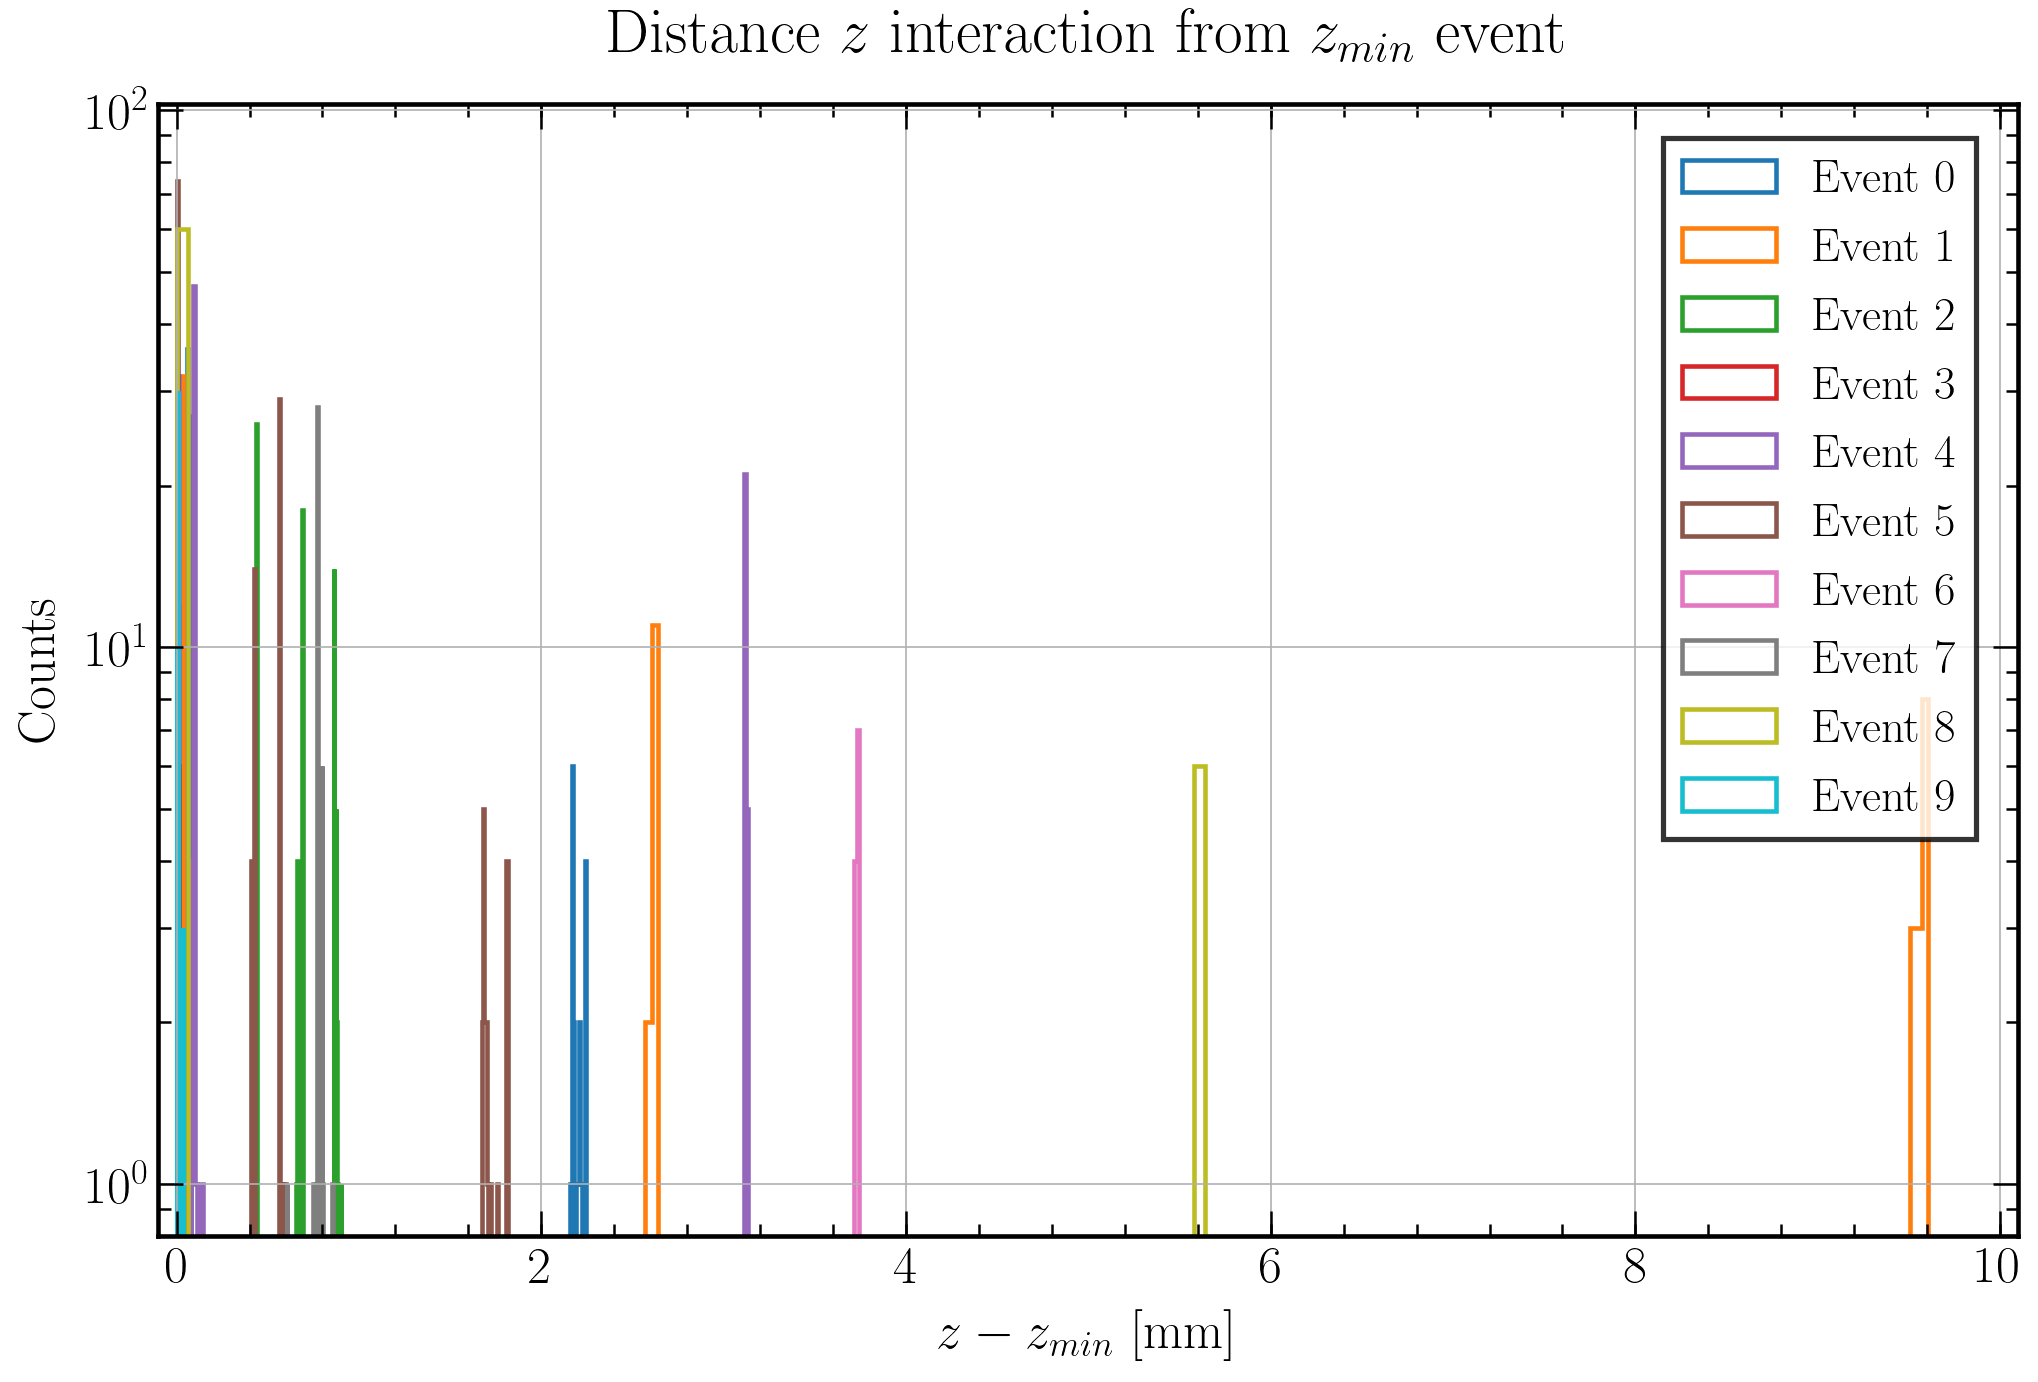

In [33]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 25
label_pad = 10
title_size = 30
title_pad = 20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = int(71.2*4)

# Data plot
i = 0
for i in range(0,10):
    plt.hist(zp_diffsmin[i], numberbins, label = 'Event '+str(i), log=True, density = False, histtype = 'step', linewidth = 2.2)


plt.xlabel('$z - z_{min}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Distance $z$ interaction from $z_{min}$ event', fontsize = title_size, pad = title_pad)

# Axes ---> Range
plt.xlim(-0.1,10.1)
plt.ylim(bottom = 0.8)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False) #, title="Ingredients"
leg.get_title().set_fontsize(label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5) 

fig.savefig(filenameprefix+"_z-zmin_zoom_exemplary.png")
plt.show()